In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pingouin as pg
from compute_rri import ecg_peaks_coupling_job, ecg_peak_job
from compute_resp_features import respiration_features_job
from circular_stats import *
from params import *
from configuration import base_folder, base_cmo

# CRS by MOI

In [9]:
def get_circ_features(angles, univals=1000, seed=None, progress_bar = False, resample=True, size_resample = 10000): # angles in radians
    if angles.size > 10000:
        rng = np.random.default_rng(seed=seed)
        angles_resampled = rng.choice(angles, size = size_resample)
    else:
        angles_resampled = angles.copy()
    
    pval = HR2P(angles_resampled, univals=univals, seed=seed, progress_bar=progress_bar)

    mu = pg.circ_mean(angles) #+ np.pi
    mu = int(np.degrees(mu))
    r = round(pg.circ_r(angles), 3)

    if mu < 0:
        mu = 360 + mu

    return pval, mu, r

def get_mean_vector_features(angles): # angles in radians

    mu = pg.circ_mean(angles) #+ np.pi
    mu = int(np.degrees(mu))
    r = round(pg.circ_r(angles), 3)

    if mu < 0:
        mu = 360 + mu

    return mu, r

def pval_stars(p):
    if not np.isnan(p):
        if p >= 0.05:
            stars = 'ns'
        elif p < 0.05 and p >= 0.01:
            stars = '*'
        elif p < 0.01 and p >= 0.001:
            stars = '**'
        elif p < 0.001:
            stars = '***'
    else:
        stars = np.nan
    return stars

def load_angles(subject = '*', session = '*'):

    """
    High level function that load angles according to arguments and concatenate them if '*' argument

    Parameters (str)
    ----------

    subject : From 'P01' to 'P31', '*' to concatenate all
    session : 'baseline' or 'music' or 'odor', '*' to concatenate all
    """

    if subject == '*':
        concat = []
        for run_key in run_keys:
            concat.append(ecg_peaks_coupling_job.get(run_key).to_dataframe())
        df_angles = pd.concat(concat).reset_index(drop = True).dropna(subset = 'Resp_Angle')
    else:
        df_angles = ecg_peaks_coupling_job.get(subject).to_dataframe()
        
    if session != '*':
        df_angles = df_angles[df_angles['session'] == session]
    return df_angles['Resp_Angle'].values

def circular_plot_angles(
    angles, 
    color = None, 
    ax=None, 
    ratio_plot = 0.4, 
    bins = 18, 
    with_rticks = True, 
    with_title = False, 
    with_arrow = True, 
    polar_ticks = 'full',
    lw = 10,
    progress_bar = False,
    univals= 100,
    seed = None,
    with_stats = True,
    return_stats = False):

    if ax is None:
        fig, ax = plt.subplots(subplot_kw=dict(projection = 'polar'), constrained_layout = True)
    if with_stats:
        pval, mu , r = get_circ_features(angles, univals=univals, seed=seed, progress_bar=progress_bar)
        stars = pval_stars(pval)
        stats = {'p':pval, 'mu':mu, 'r':r}

    N_events = angles.size # number of angles computed and distributed = number of events detected and computed (all subjects pooled)
    values, bins_hist, patches = ax.hist(angles, bins = bins, density = True, edgecolor = 'black', color = color ) # polar histogram of distribution of angles of all subjects (in radians)
    rmax = np.max(values)
    max_rticks = rmax + 0.05 * rmax

    if with_rticks:
        ax.set_rticks(np.arange(0,max_rticks,0.05))
        ax.set_rmax(max_rticks)
    else:
        ax.set_rticks([])

    step = np.pi / 180
    theta_inspi = np.arange(0, ratio_plot * 2*np.pi, step)
    theta_expi = np.arange(ratio_plot * 2*np.pi, 2*np.pi, step)
    for theta, color in zip([theta_inspi, theta_expi],['r','k']):
        r_plot = np.ones(theta.size) * rmax * 1.05
        ax.plot(theta, r_plot, lw = lw, color =color)
    
    if polar_ticks == 'full':
        ax.set_xticks(np.deg2rad([0, 90 , ratio_plot * 360 , 180 , 270])) # at this angles in degrees, ticks labels will be present
        ax.set_xticklabels(['Start', '90°', 'I>E', '180°','270°']) # labelize polar plot angles
    elif polar_ticks == 'light':
        ax.set_xticks([ratio_plot * 2*np.pi]) # at this angles in degrees, ticks labels will be present
        ax.set_xticklabels(['I>E']) # labelize polar plot angles
    
    if with_title:
        if with_stats:
            ax.set_title(f'N : {N_events} \n Mean Angle : {mu}° - MVL : {r} \n p-HermansRasson : {stars}')
        else:
            ax.set_title(f'N : {N_events}')
    if with_arrow:
        mu, r = get_mean_vector_features(angles)
        color_arrow = 'red'
        ax.arrow(np.deg2rad(mu), 0, 0, r, alpha = 1, width = 0.3, label = 'r', color=color_arrow, length_includes_head=True, head_width = 0.4, head_length =  0.01)
        
    return ax

def get_cycles_ratios(run_keys):
    concat = []
    for run_key in run_keys:
        to_concat = resp_tag_job.get(run_key).to_dataframe()
        to_concat['subject'] = run_key
        concat.append(to_concat)
    pooled_features = pd.concat(concat)

    cycle_ratio_by_sub_by_stage = pooled_features.groupby(['subject','sleep_stage'])['cycle_ratio'].mean(numeric_only = True).reset_index()
    mean_cycle_ratio_by_stage = pooled_features.groupby('sleep_stage')['cycle_ratio'].mean(numeric_only = True).reset_index()
    mean_cycle_ratio_by_stage.insert(0, 'subject','mean')
    cycles_ratios = pd.concat([cycle_ratio_by_sub_by_stage, mean_cycle_ratio_by_stage])
    return cycles_ratios

def readable_pval(pval):
    return round(pval, 4) if pval >= 0.001 else '< 0.001'

In [10]:
concat = []
for run_key in run_keys:
    concat.append(ecg_peaks_coupling_job.get(run_key).to_dataframe())
ecg_angles = pd.concat(concat).reset_index(drop = True).dropna(subset = 'Resp_Angle')

In [11]:
ecg_angles

,peak_index,peak_time,Participant,session,Resp_Angle
2,1788,1.788,P01,baseline,0.007095
3,2533,2.533,P01,baseline,0.271373
4,3256,3.256,P01,baseline,0.527847
5,3958,3.958,P01,baseline,0.776871
6,4673,4.673,P01,baseline,0.031887
...,...,...,...,...,...
66072,595382,595.382,P31,odor,0.306699
66073,596185,596.185,P31,odor,0.454881
66074,597011,597.011,P31,odor,0.607308
66075,597889,597.889,P31,odor,0.769330


In [12]:
bins

NameError: name 'bins' is not defined

In [ ]:
bin_width

In [ ]:
bins[1] - bins[0]

In [ ]:
ecg_angles

In [ ]:
# bin_size = 0.025 # radians
n_bins = 101

for sub in subject_keys[:8]:
    fig, axs = plt.subplots(nrows = len(session_keys), figsize = (12,8), constrained_layout = True)
    fig.suptitle(sub)
    for r, ses in enumerate(session_keys):
        ax = axs[r]
        mask = (ecg_angles['Participant'] == sub) & (ecg_angles['session'] == ses)
        angles = ecg_angles[mask]['Resp_Angle'].values
        
        resp = respiration_features_job.get(sub, ses).to_dataframe()
        ratio = resp['cycle_ratio'].median()
        
        # bins = np.arange(0, 1, bin_size)
        bins = np.linspace(0, 1, n_bins)
        count, bins = np.histogram(angles, bins=bins)
        
        # bin_width =  np.median(np.diff(bins))
        bin_width =  bins[1] - bins[0]
        duration_of_bins = round(resp['cycle_duration'].median()  / n_bins, 2)
        ax.bar(bins[:-1], count, edgecolor = 'k', align='edge', width = bin_width)
        # ax.axvline(ratio, color = 'r', label = 'Inspi>Expi transition')
        ax.set_xlabel('Respiratory phase (0-1)')
        ax.set_ylabel('Number of R peaks')
        # ax.set_title(f'session = {ses}    (bin size = {bin_size} radians = {duration_of_bins} secs)')
        ax.set_title(f'session = {ses}, N Bins = {n_bins} = {duration_of_bins} secs / bin')
        ax.legend(fontsize = 6, loc = 2)
    # fig.savefig(base_folder / 'Figures' / 'ecg_peak_phase_coupling_resp' / f'{sub}.png', dpi = 500, bbox_inches = 'tight')
    plt.show()

# CRS by physio

In [13]:
from physio.cyclic_deformation import time_to_cycle

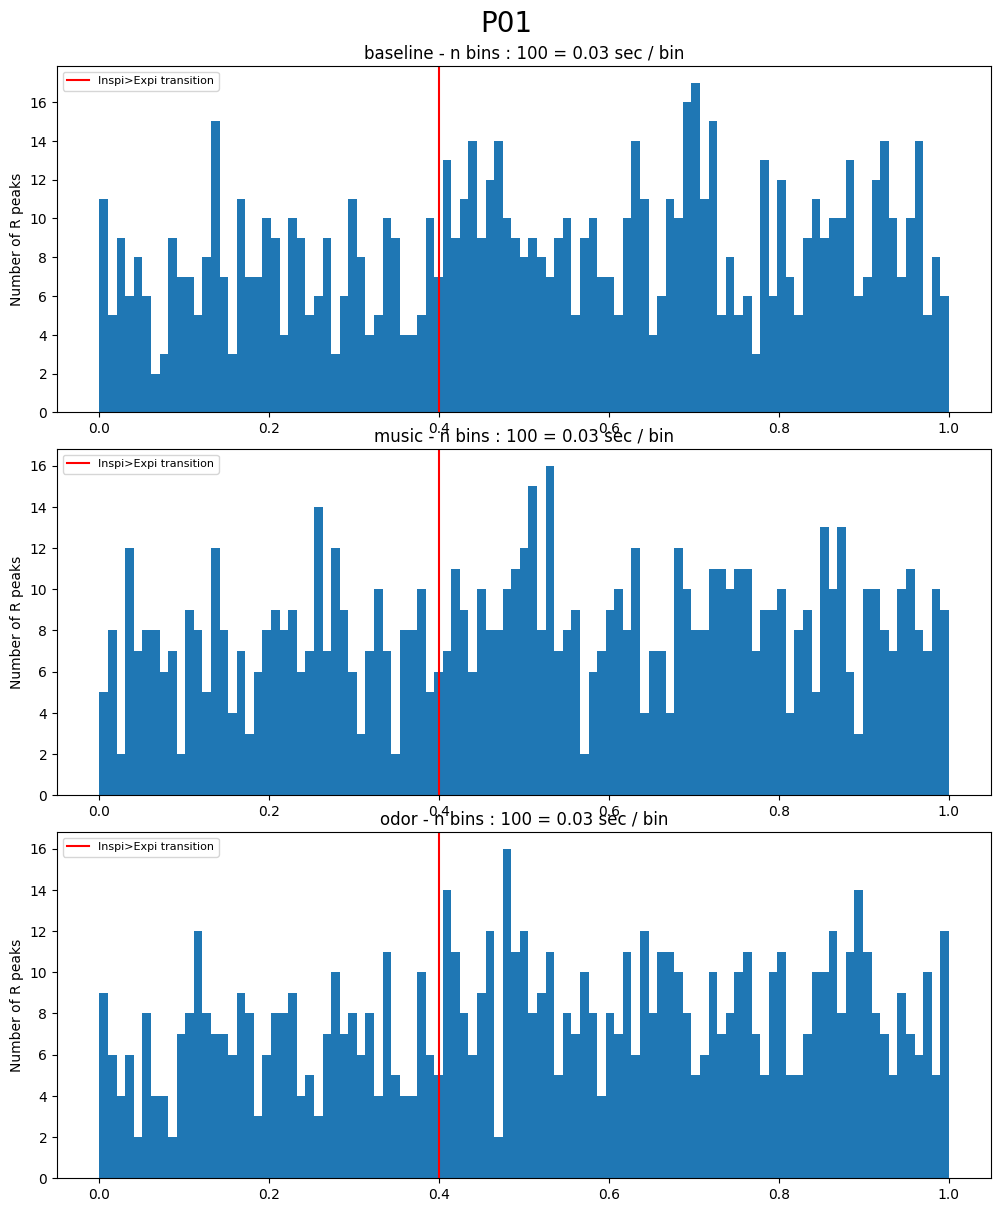

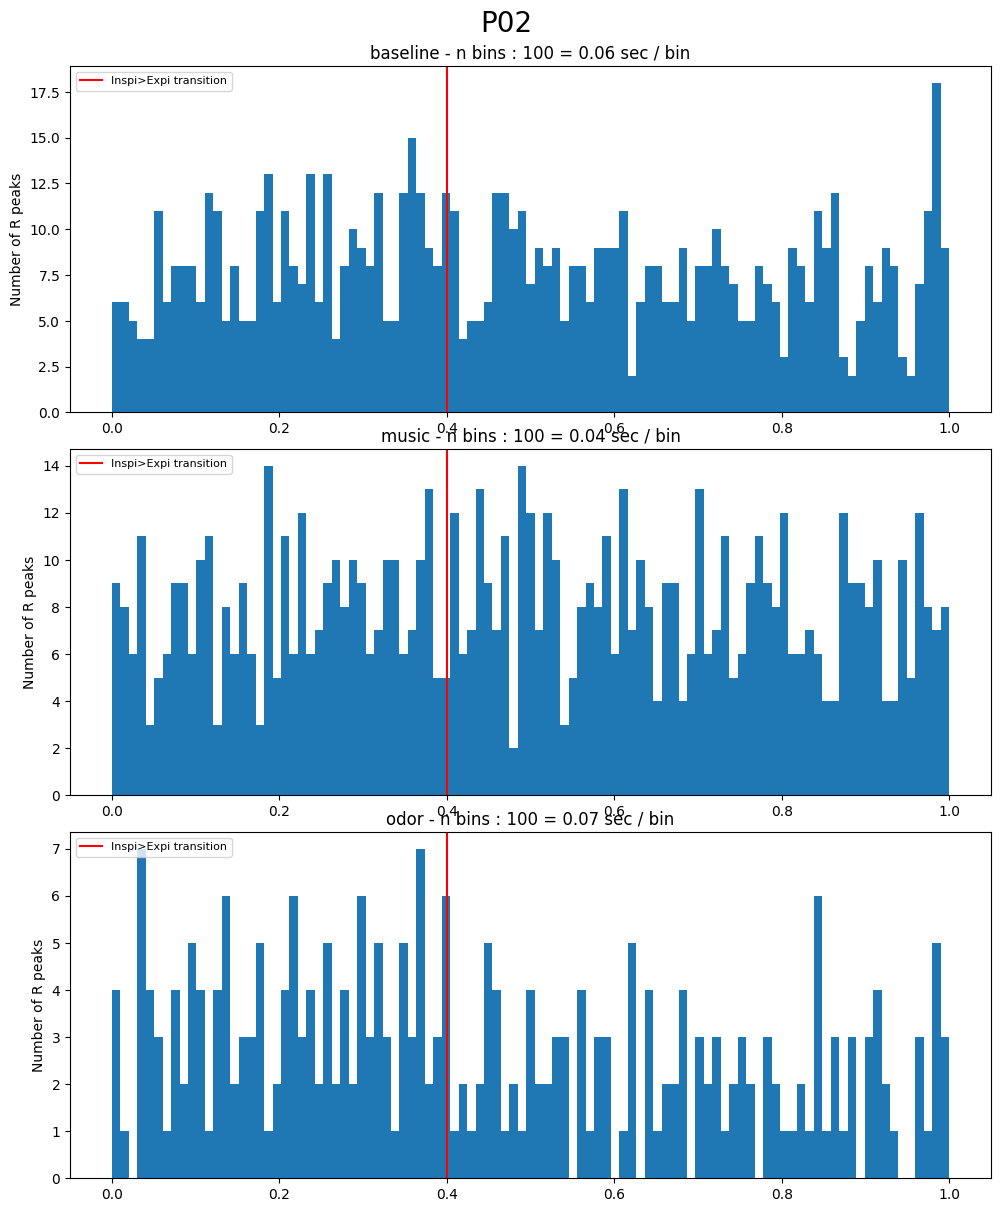

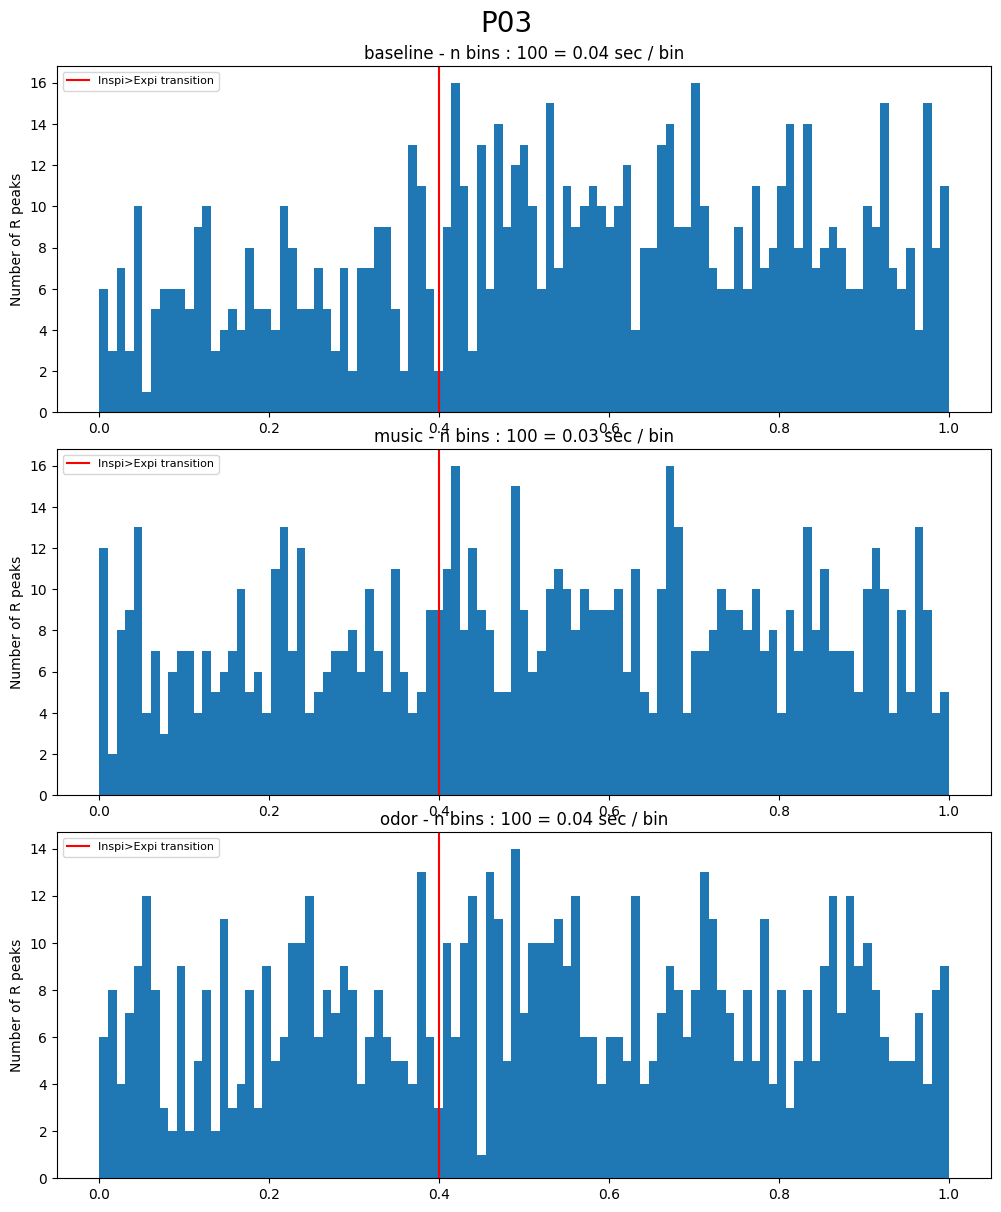

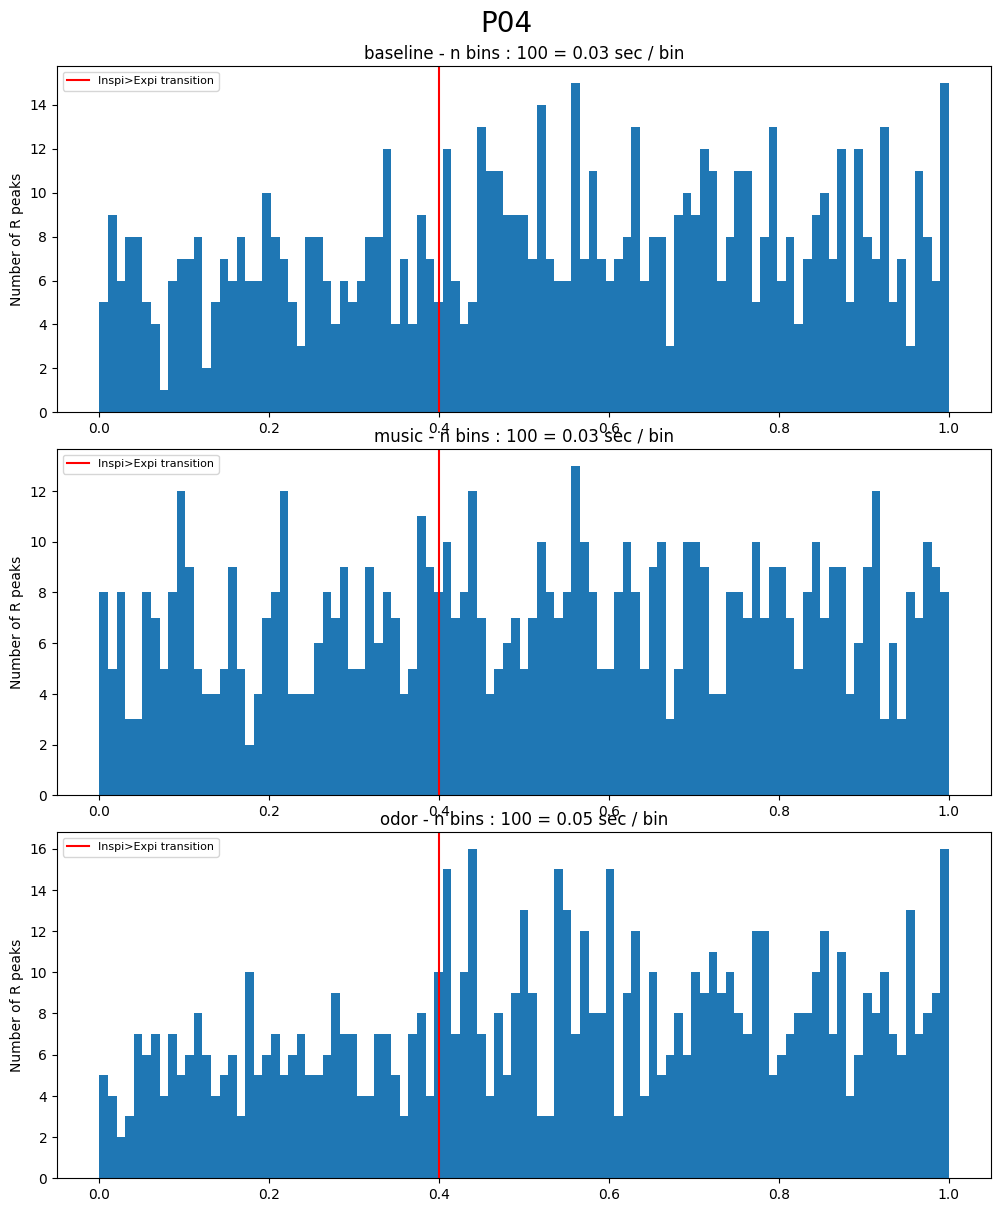

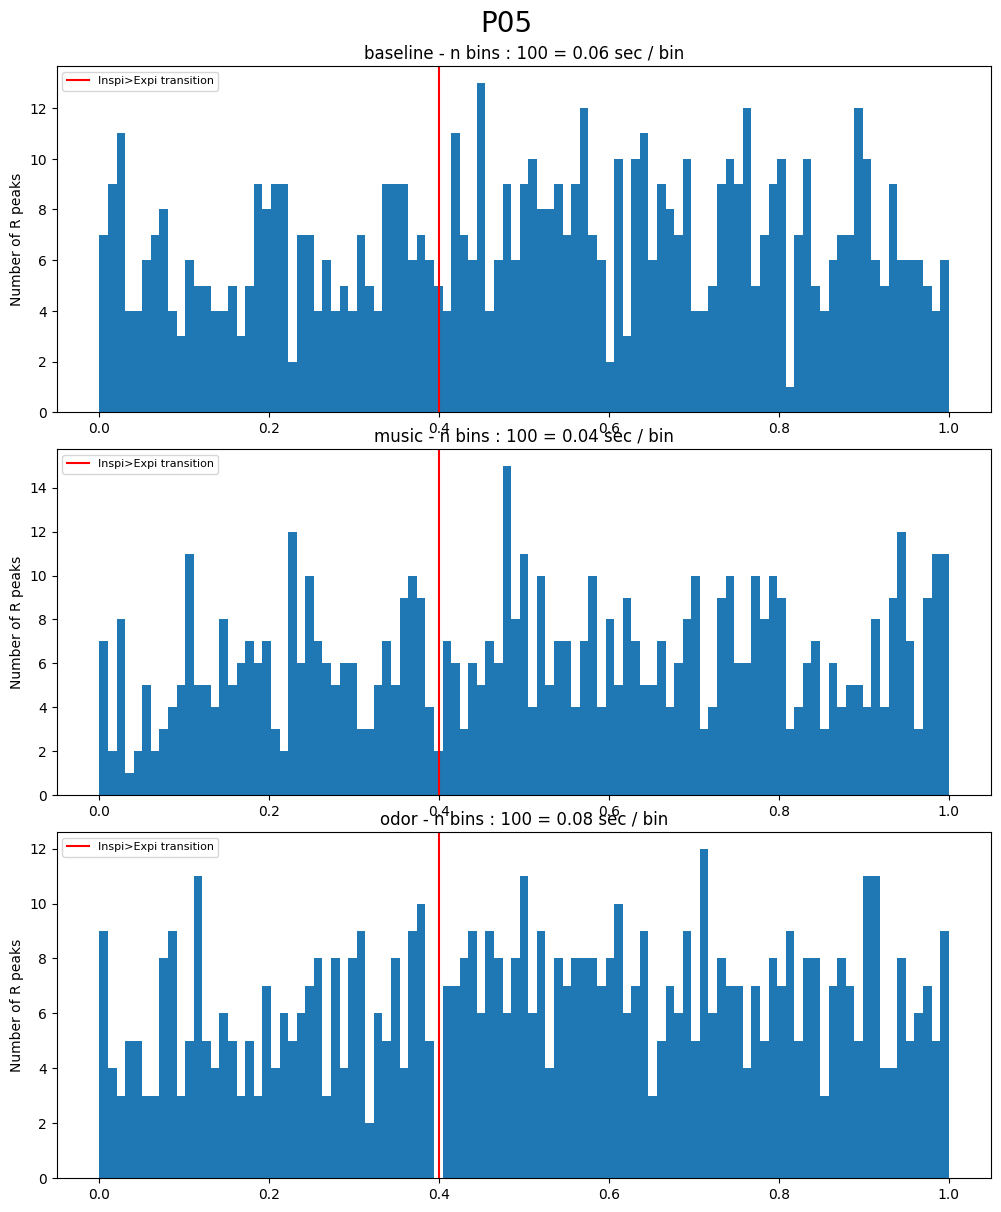

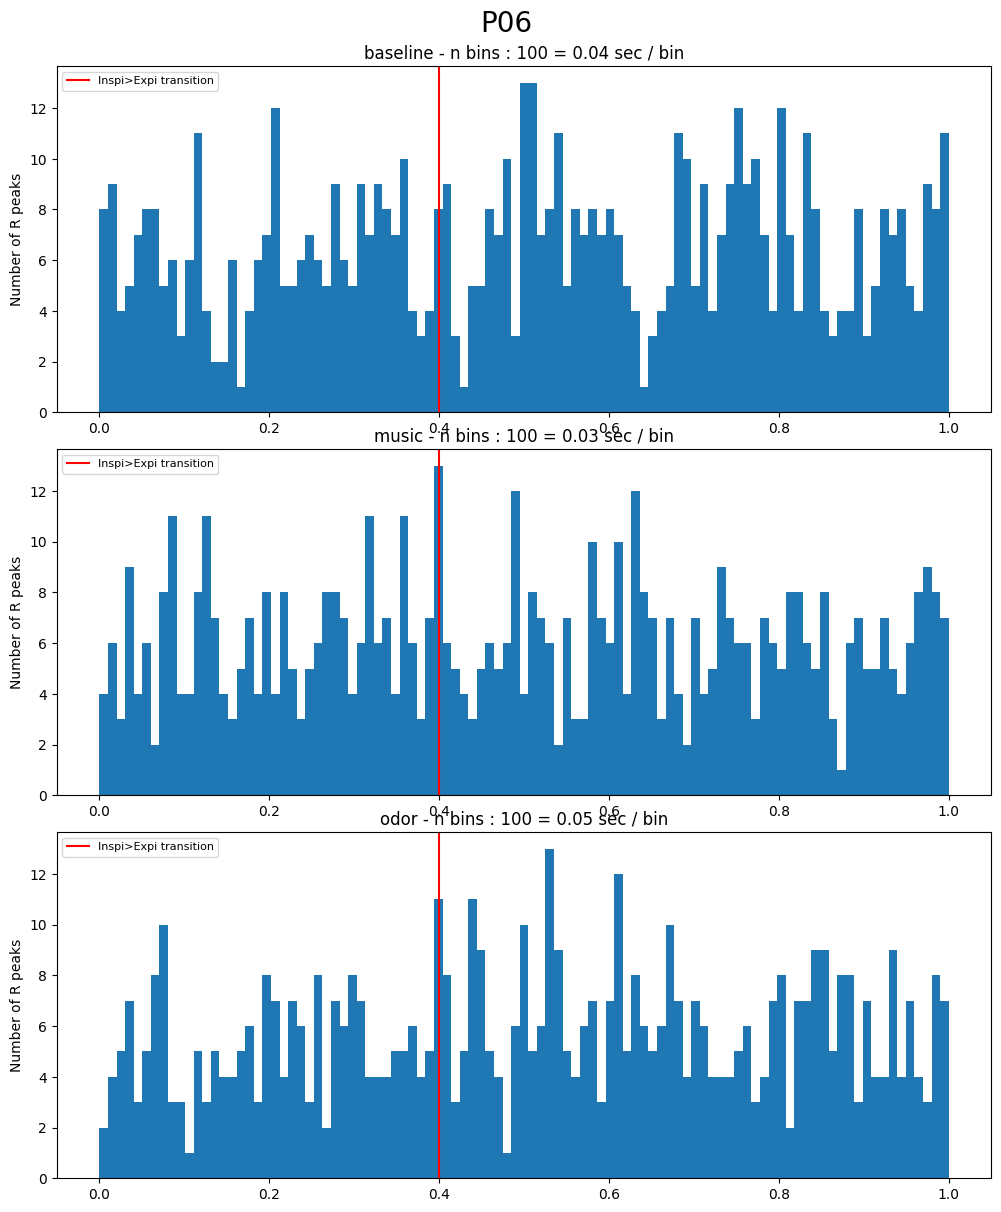

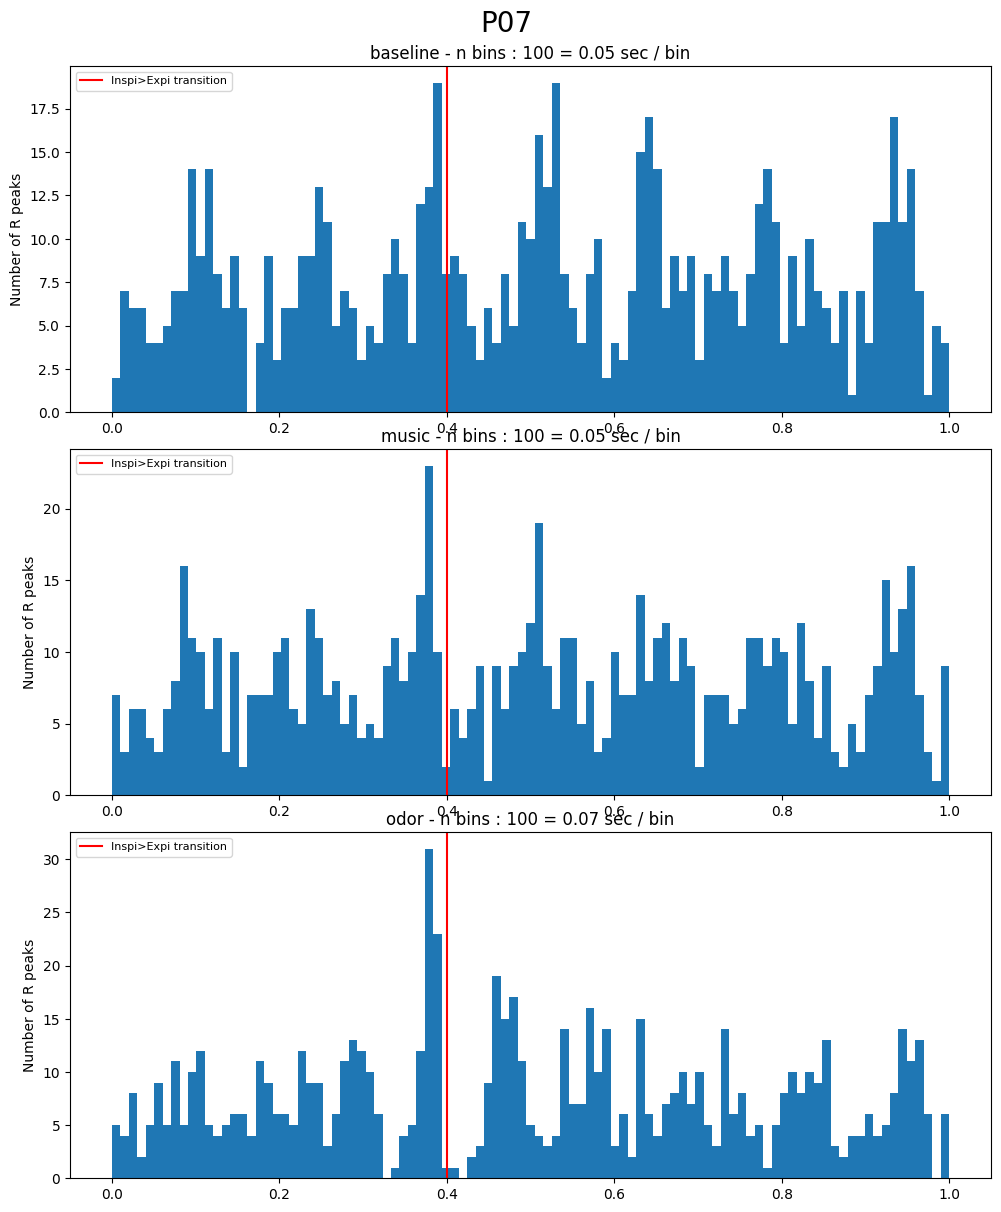

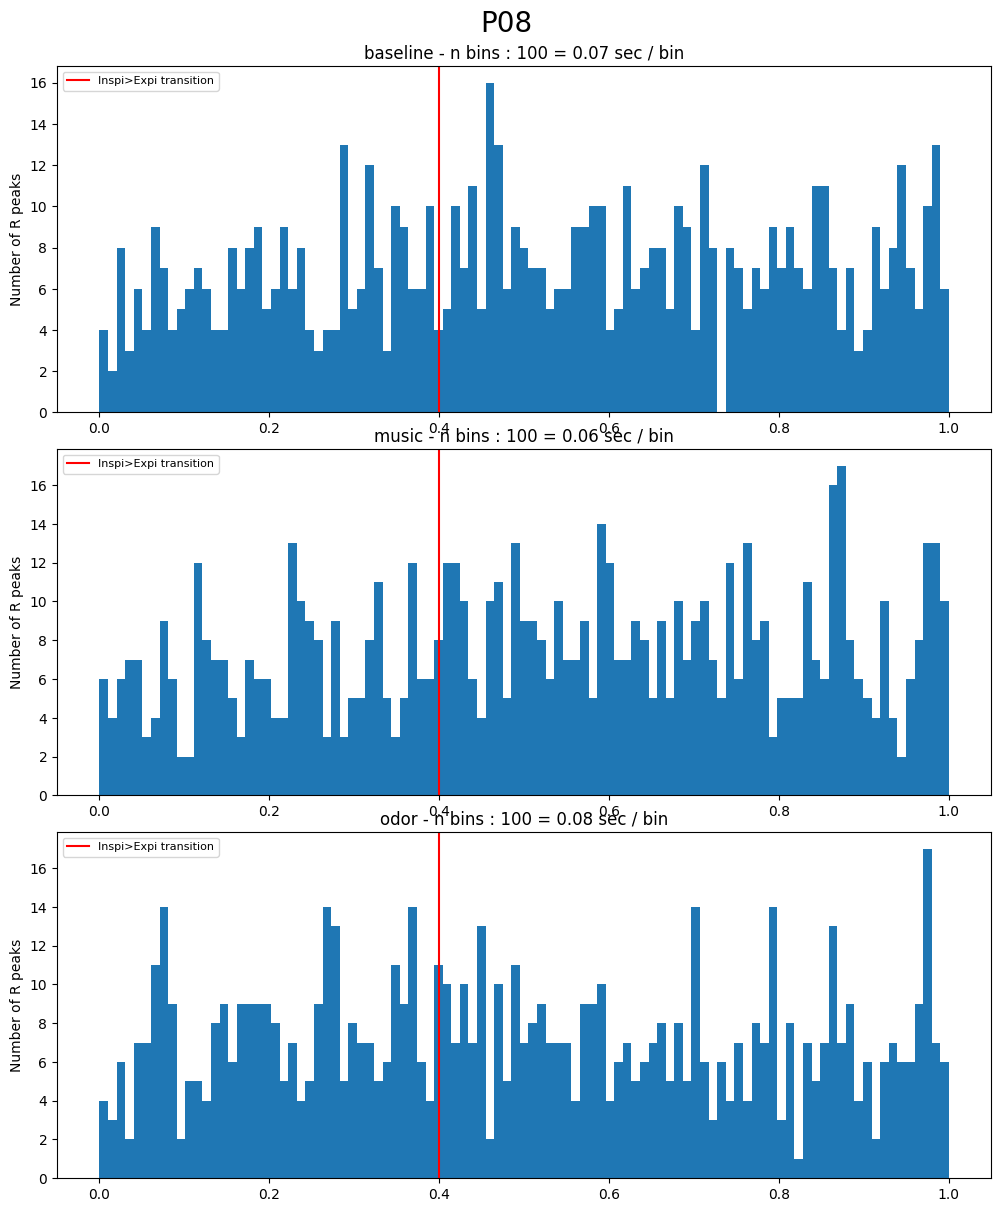

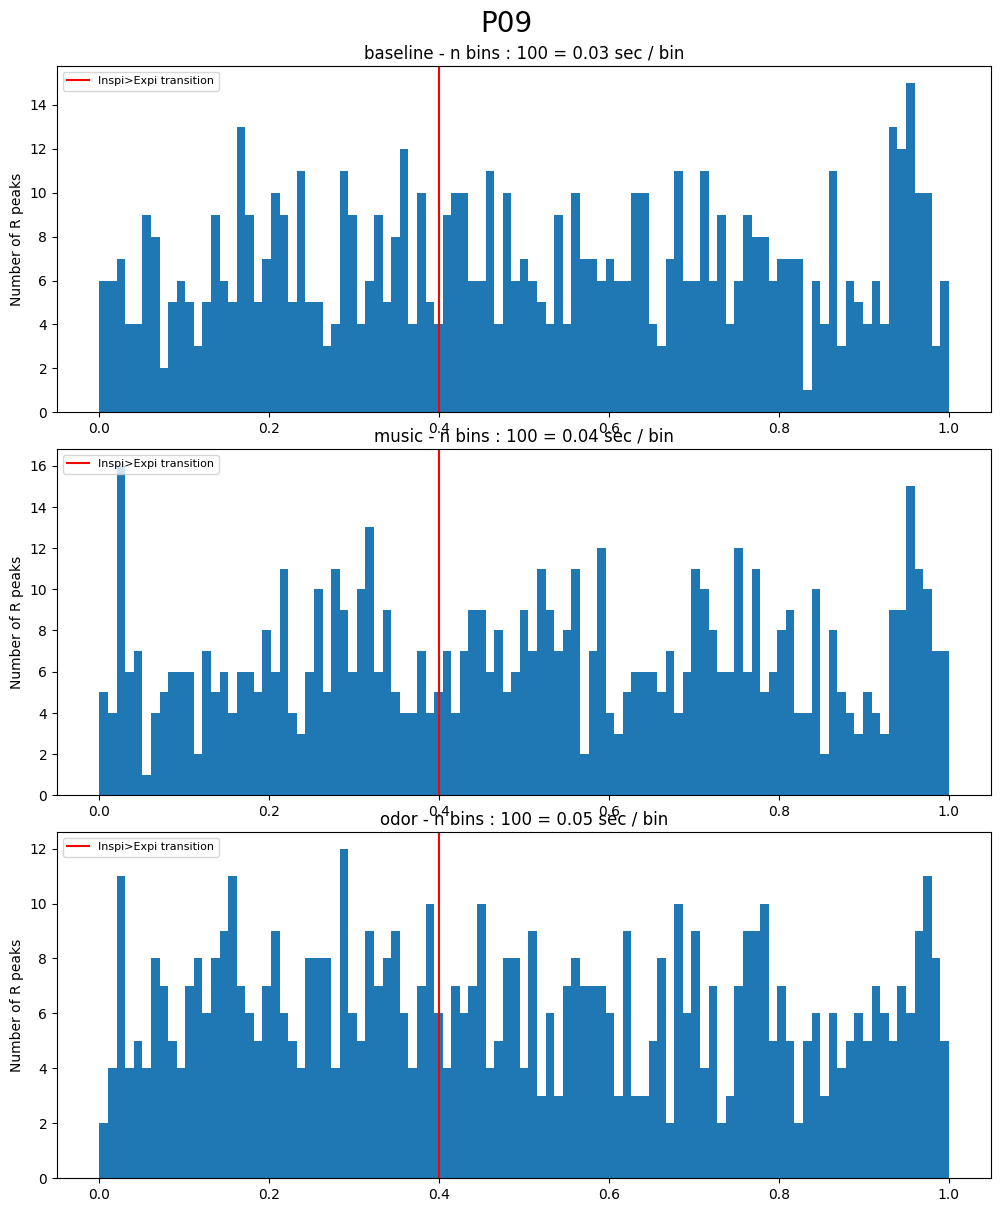

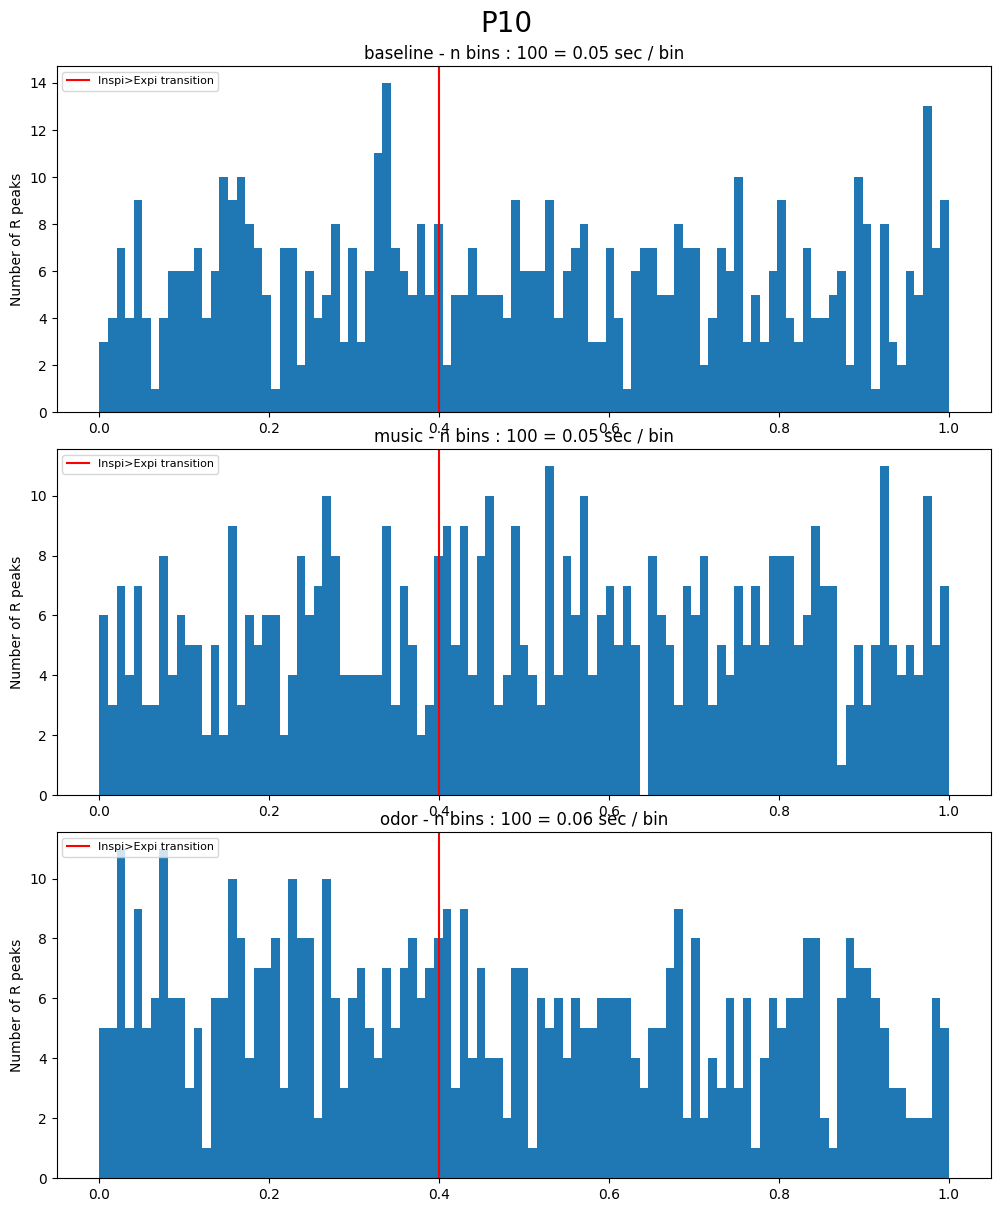

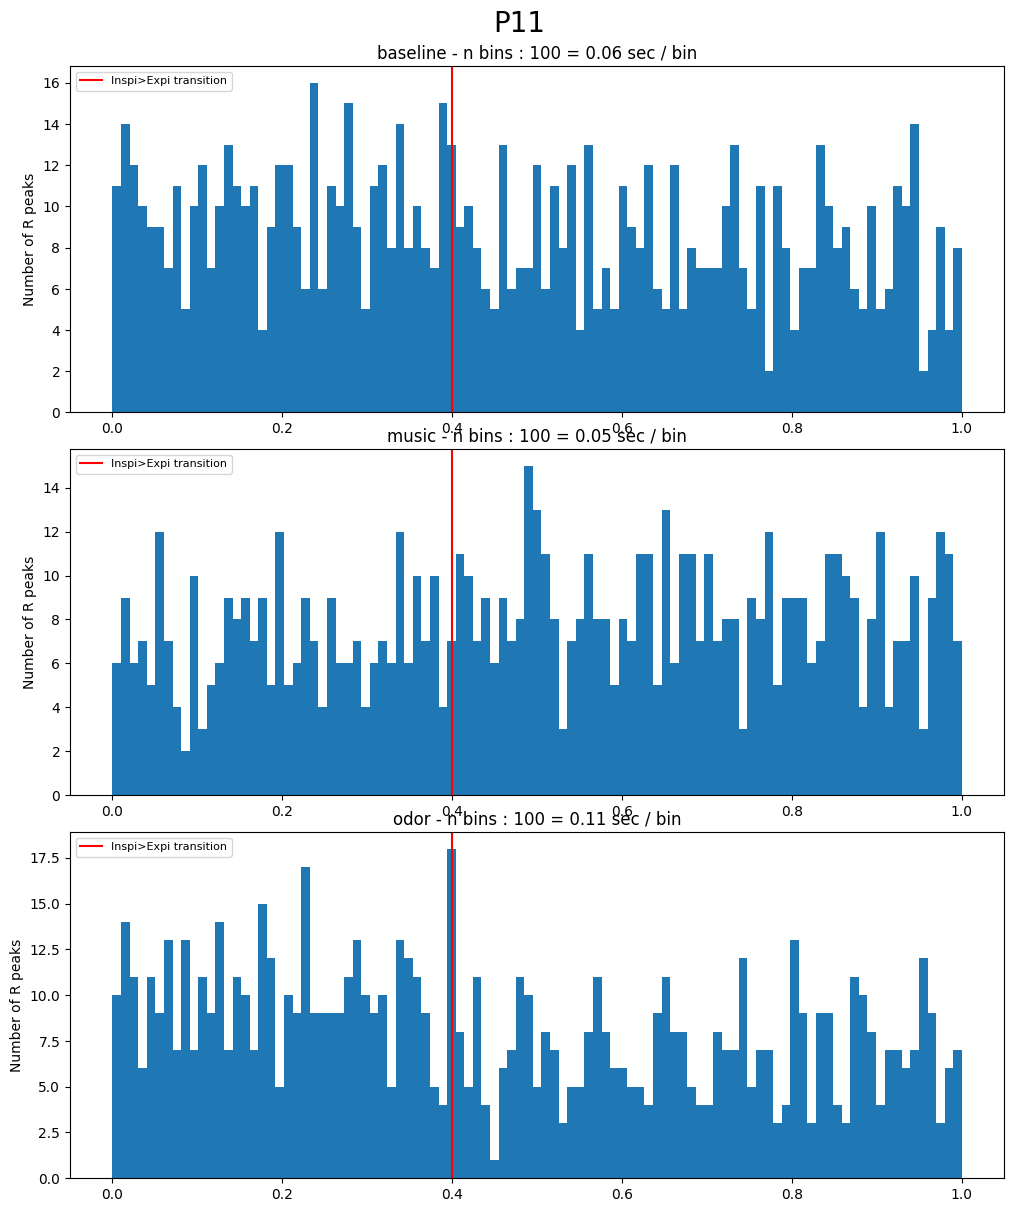

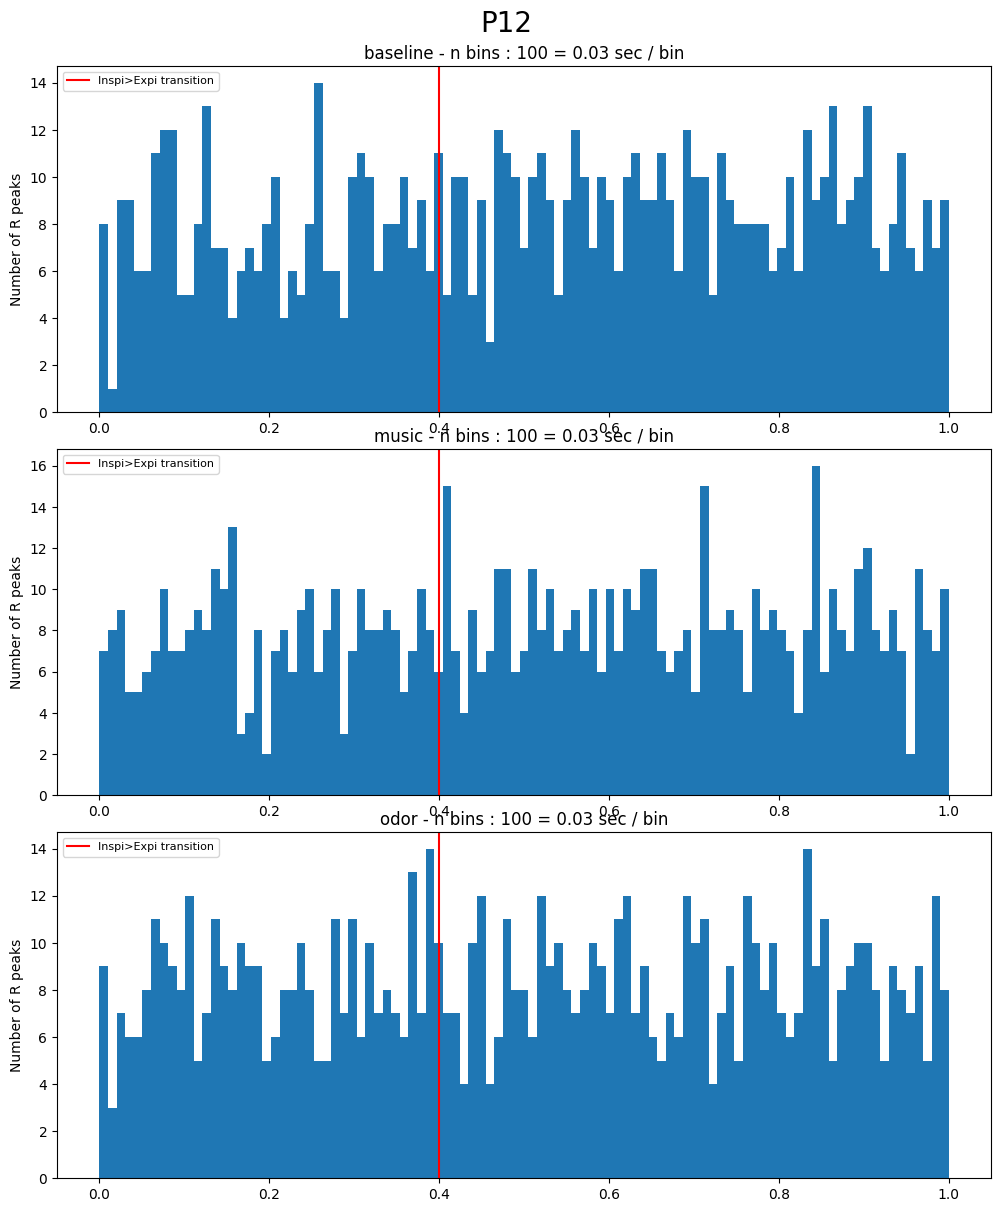

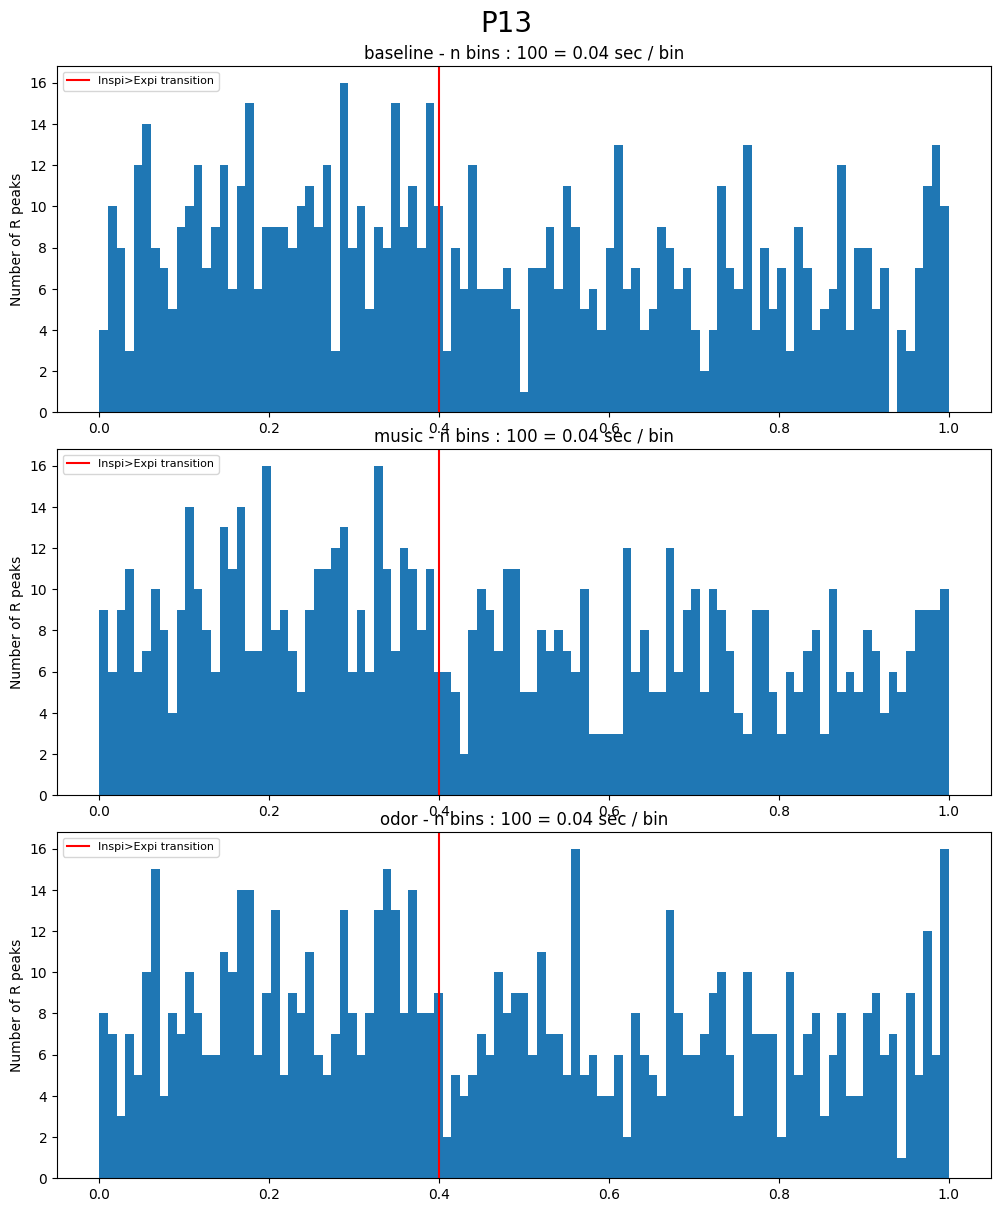

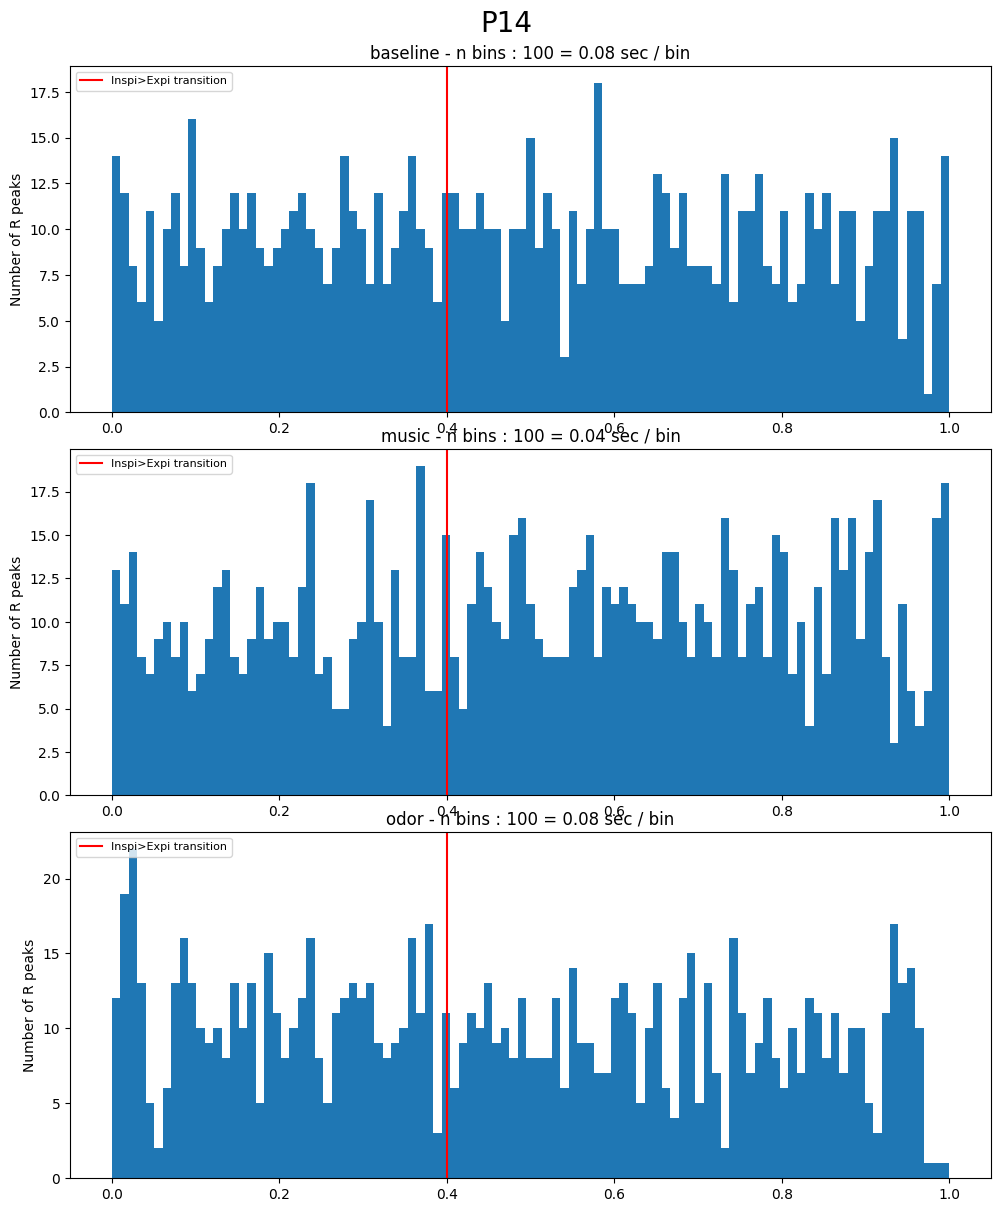

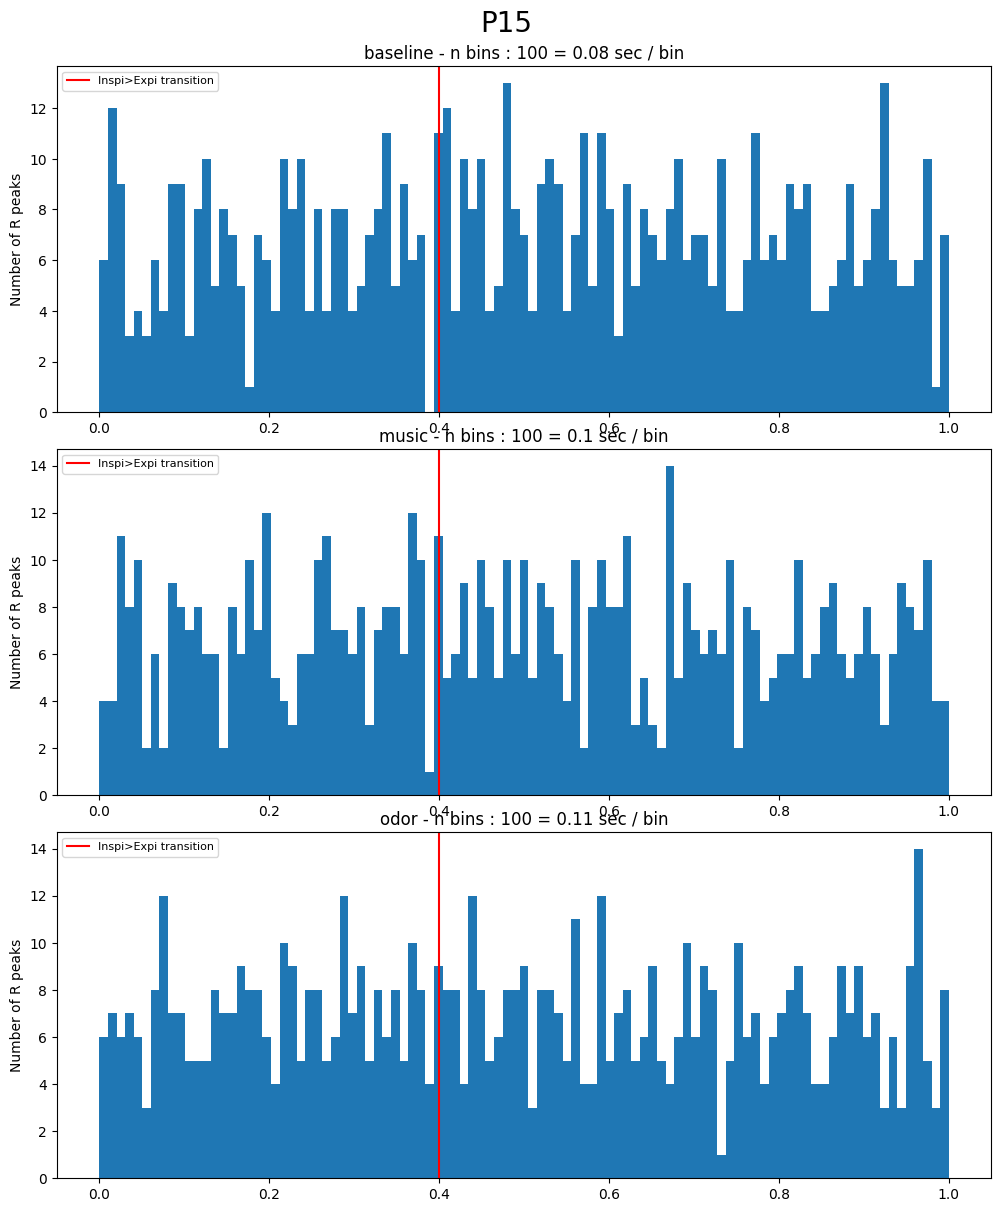

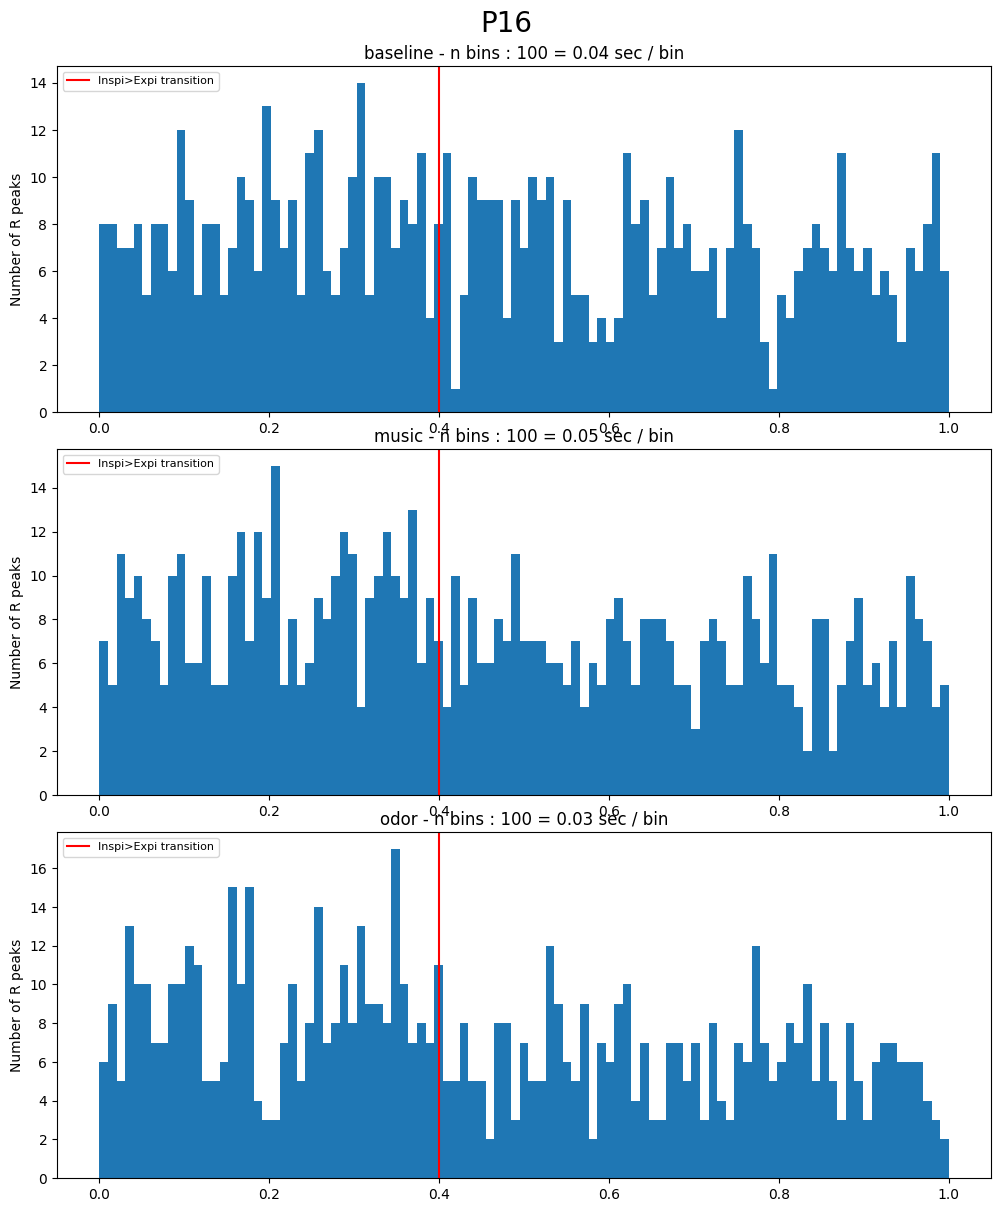

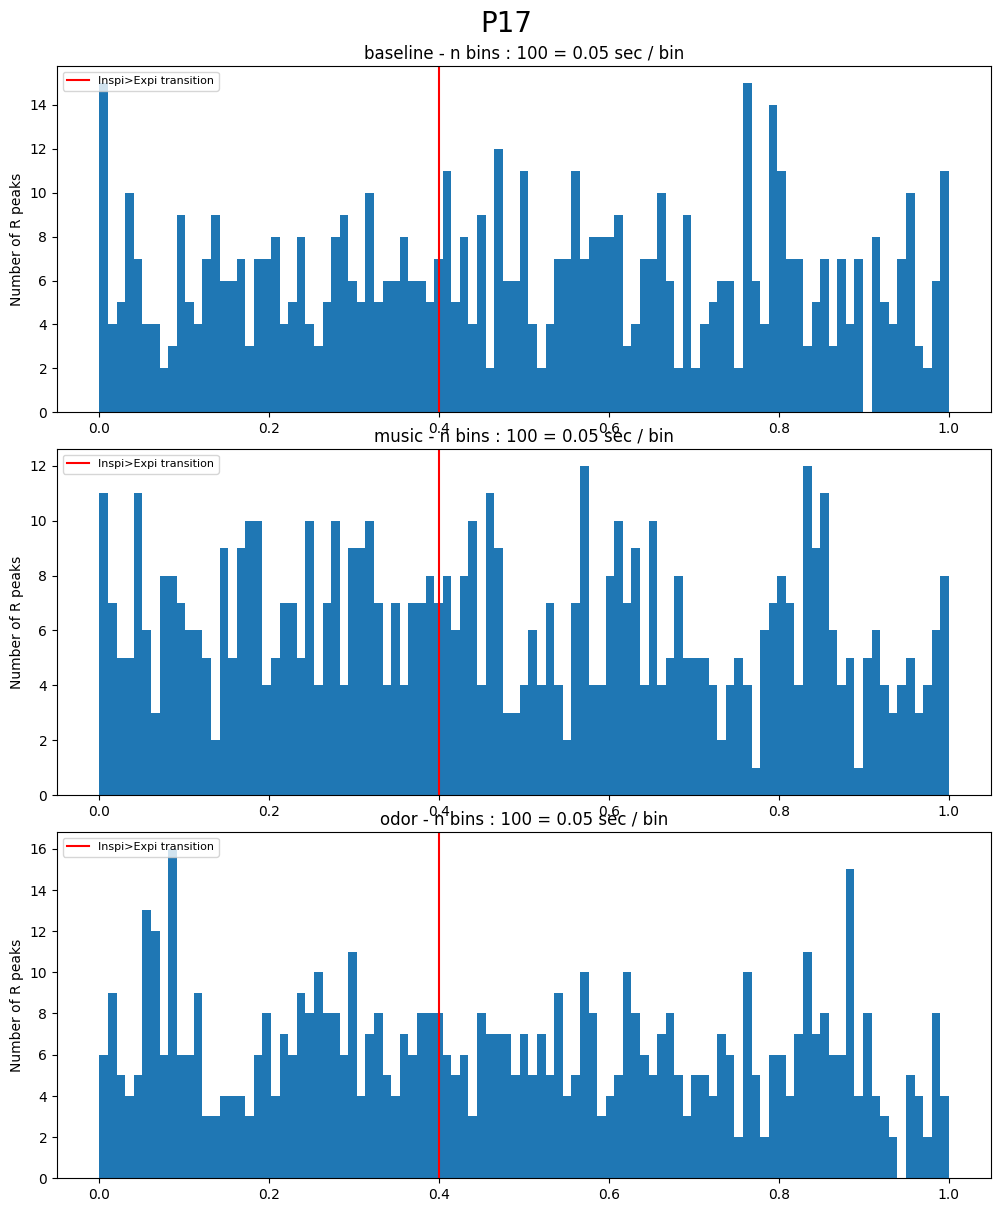

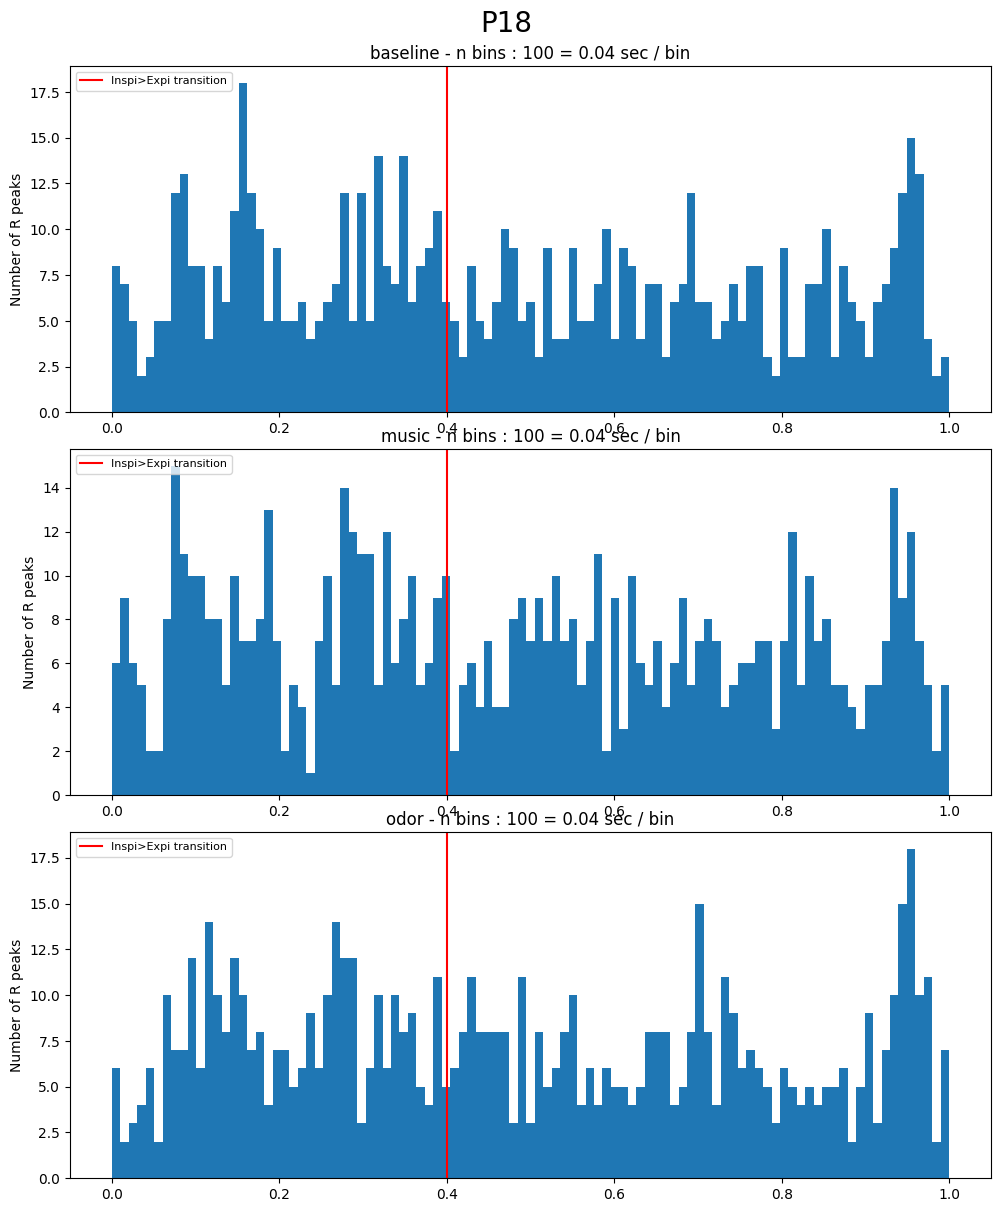

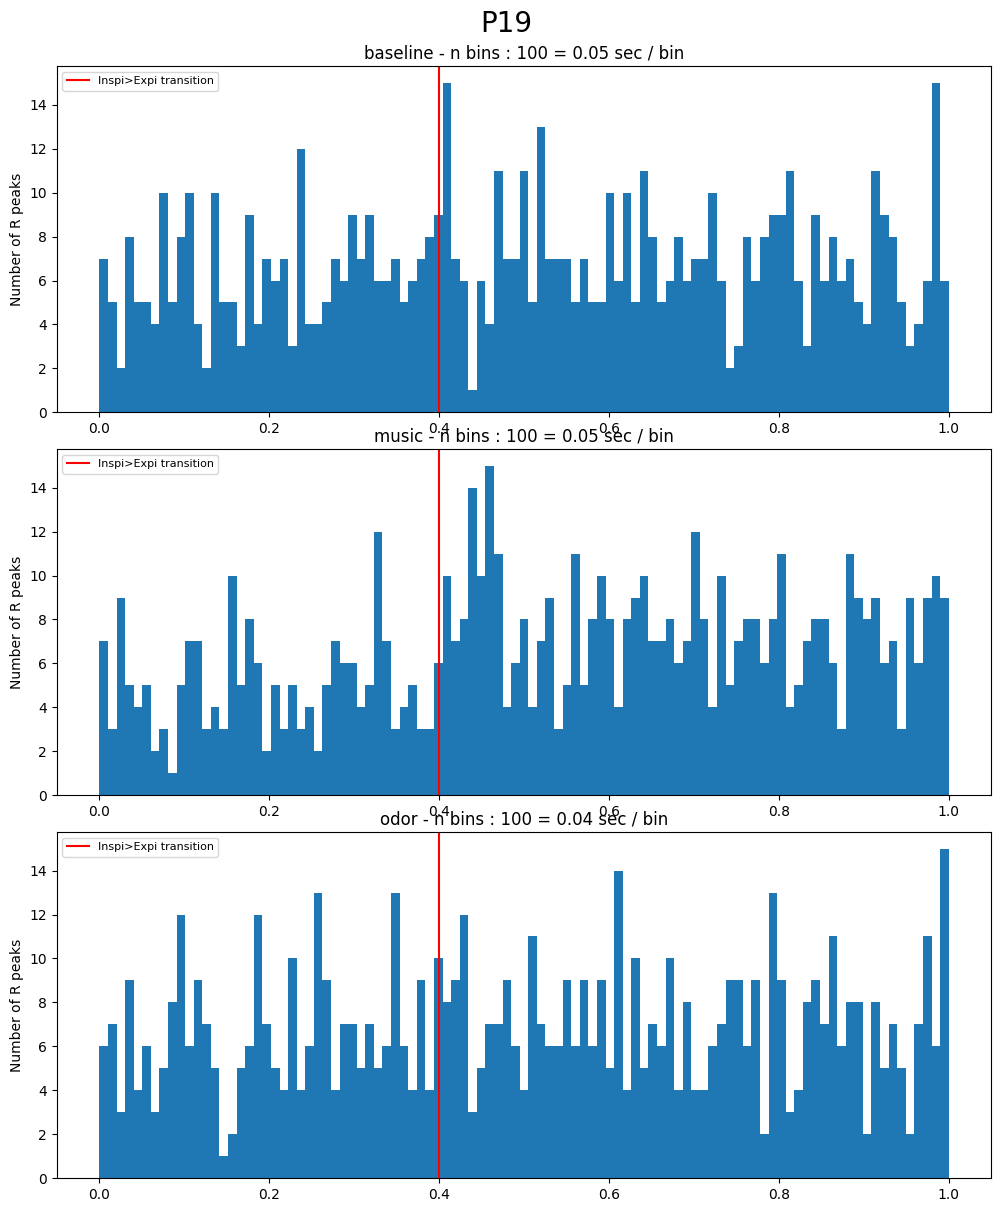

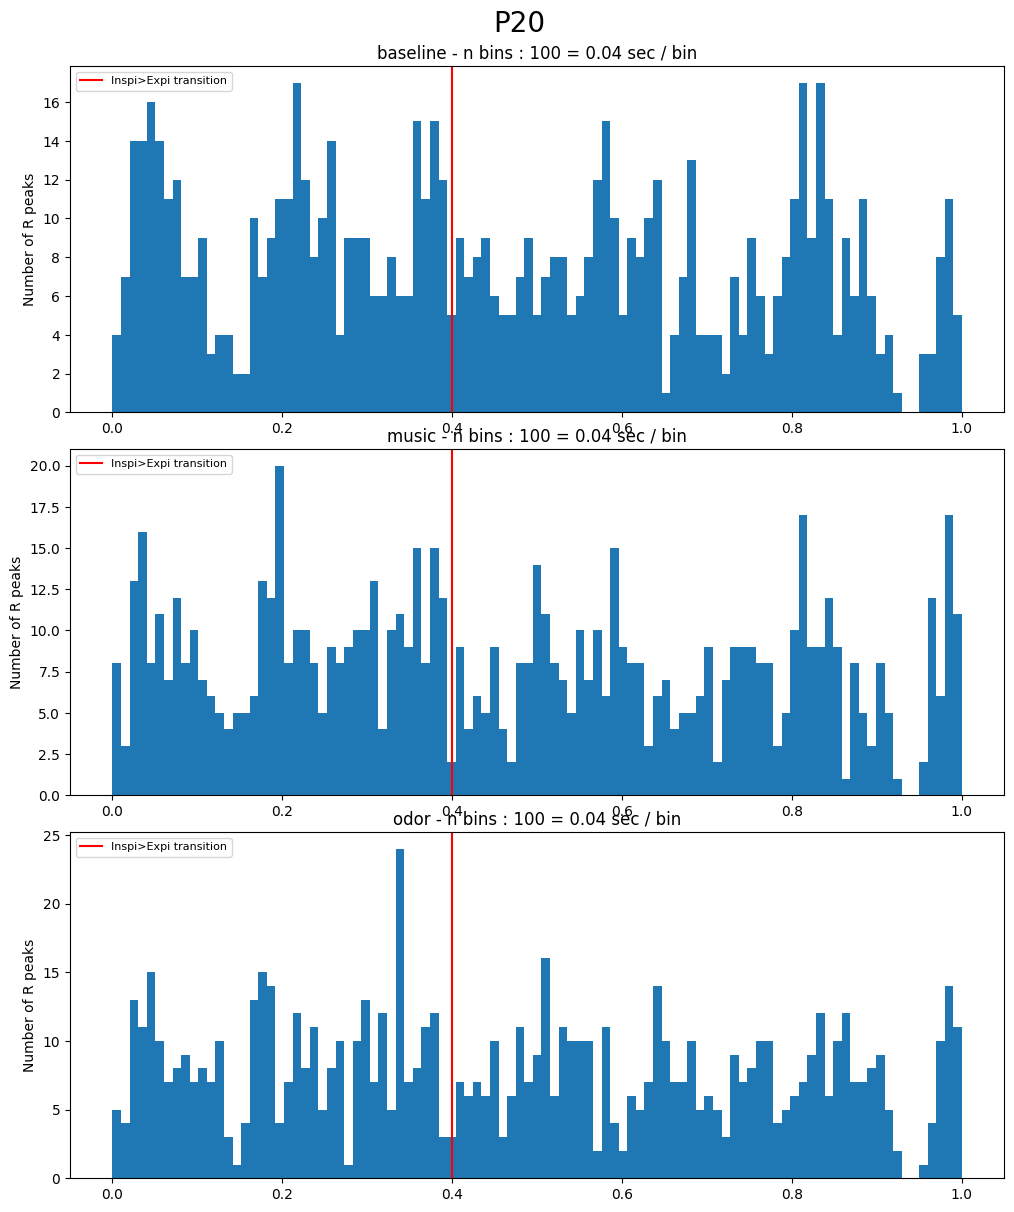

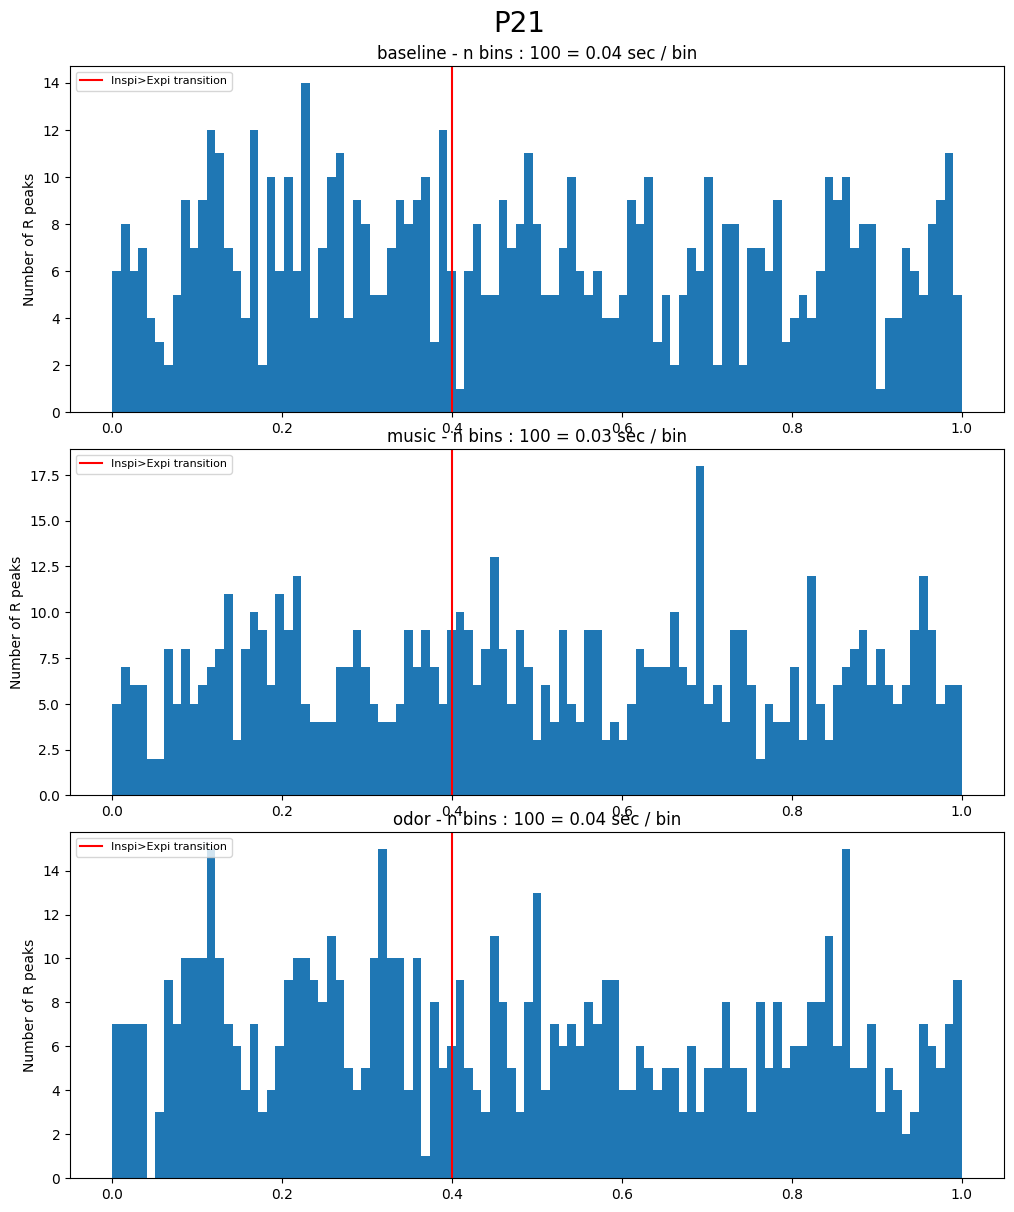

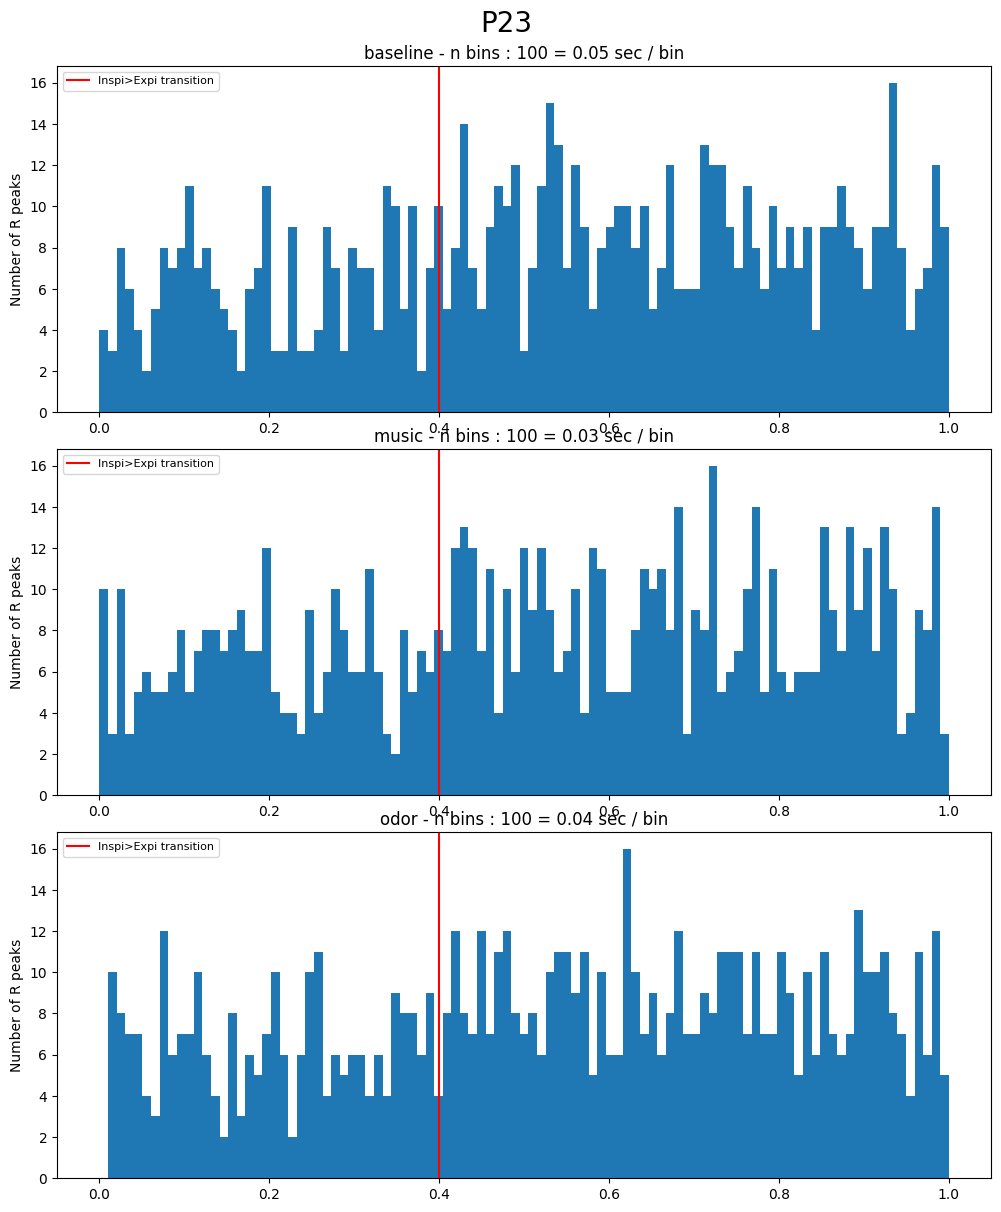

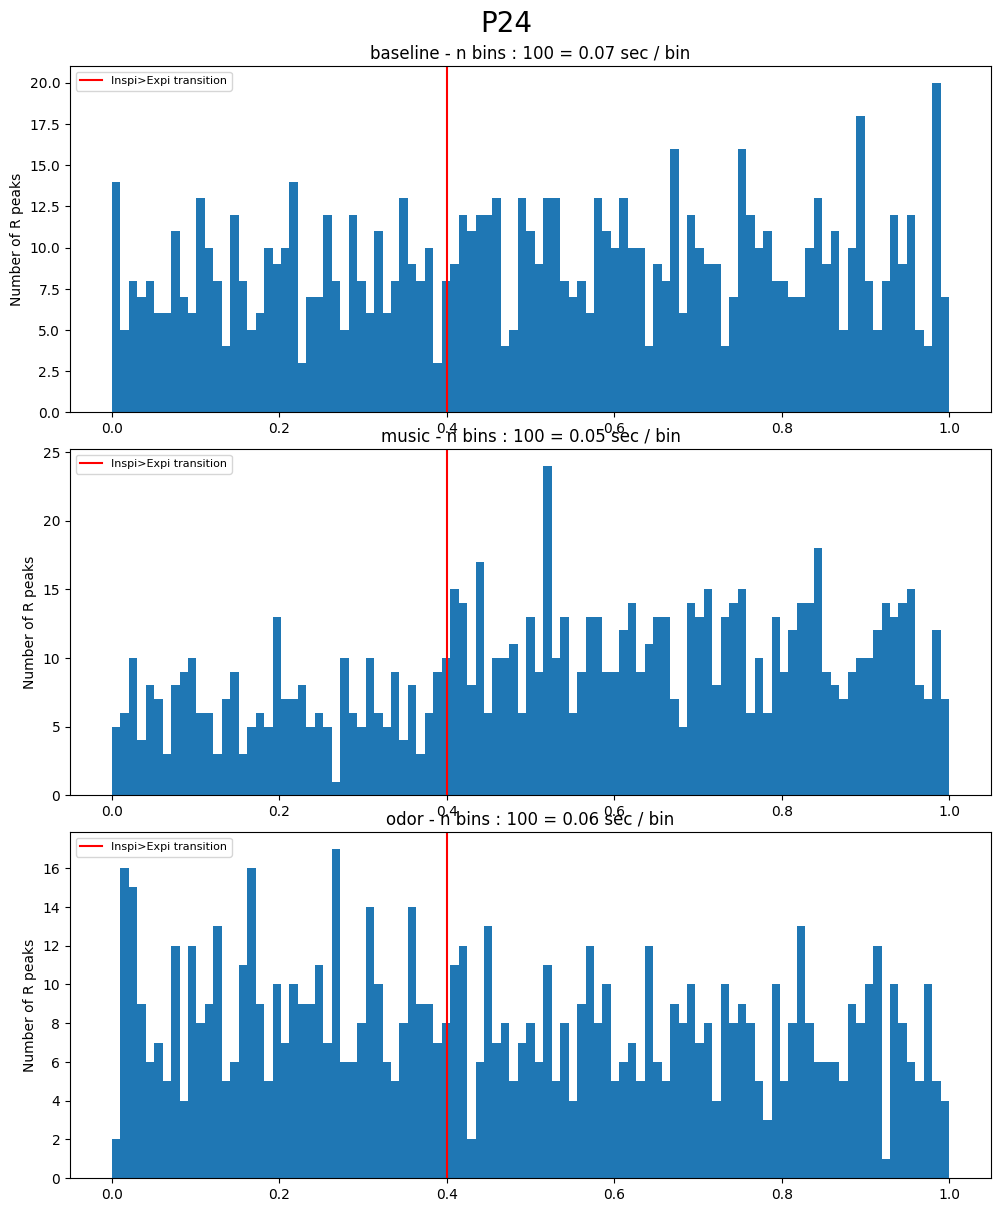

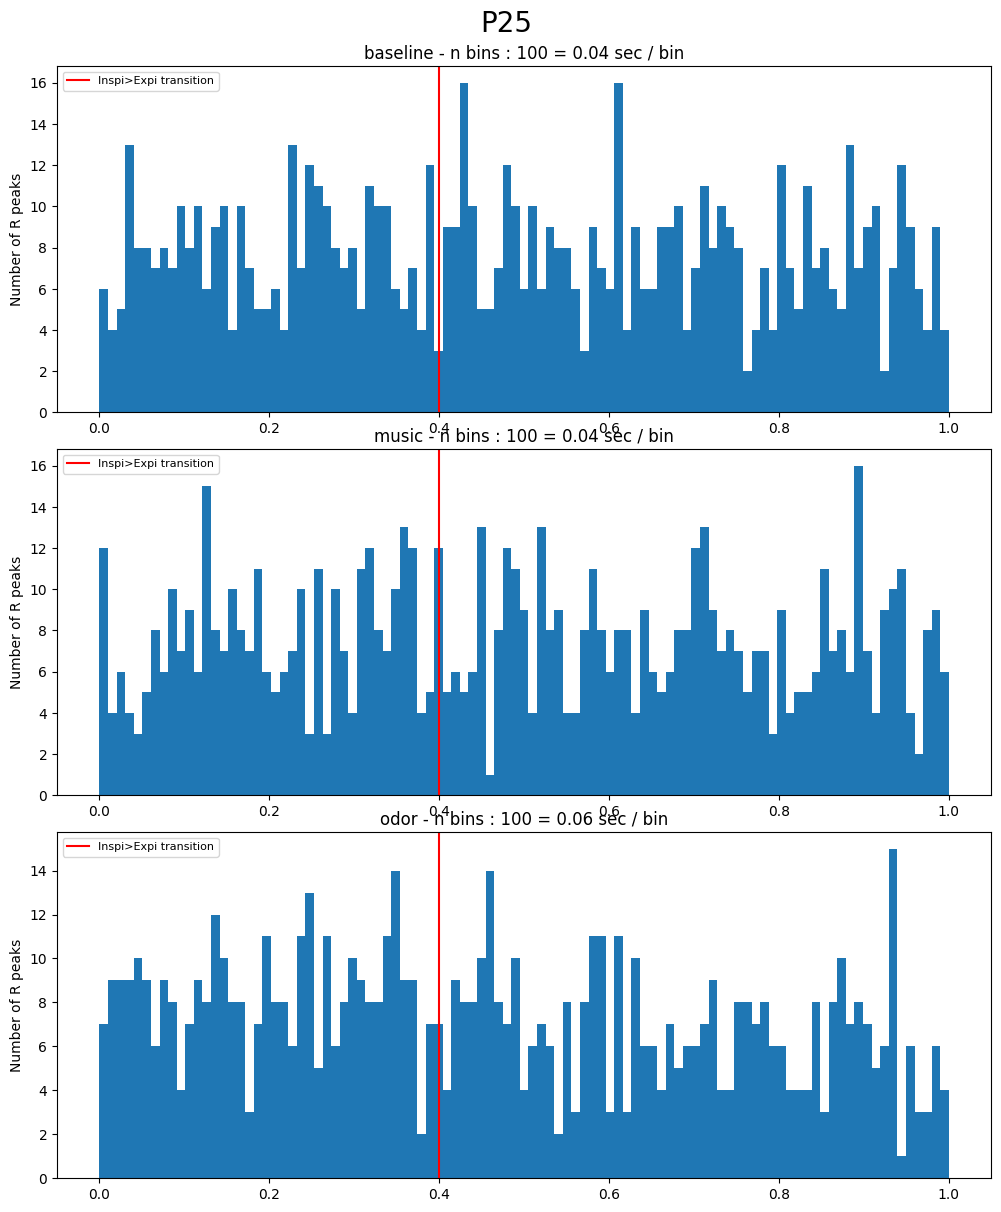

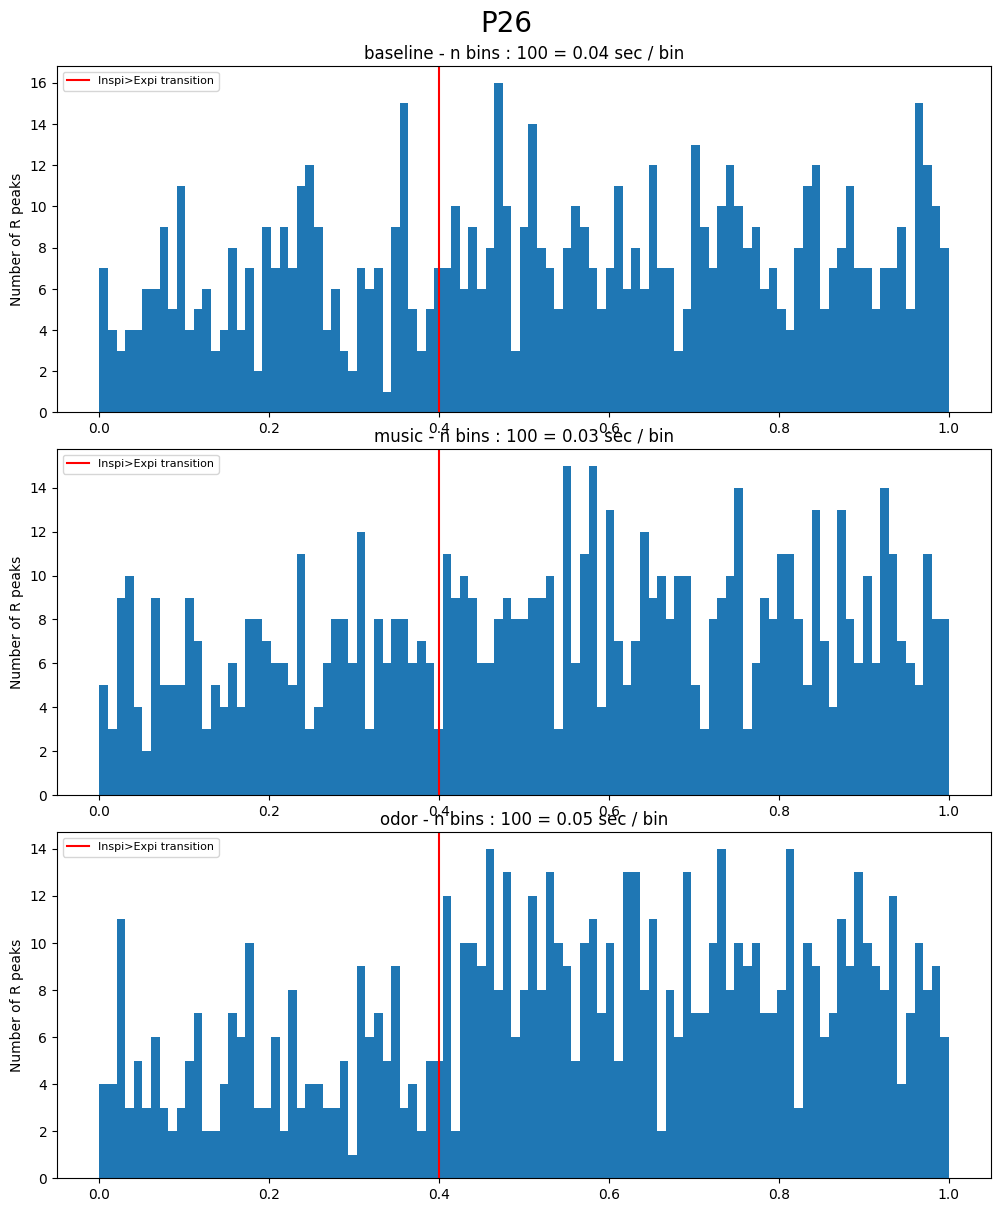

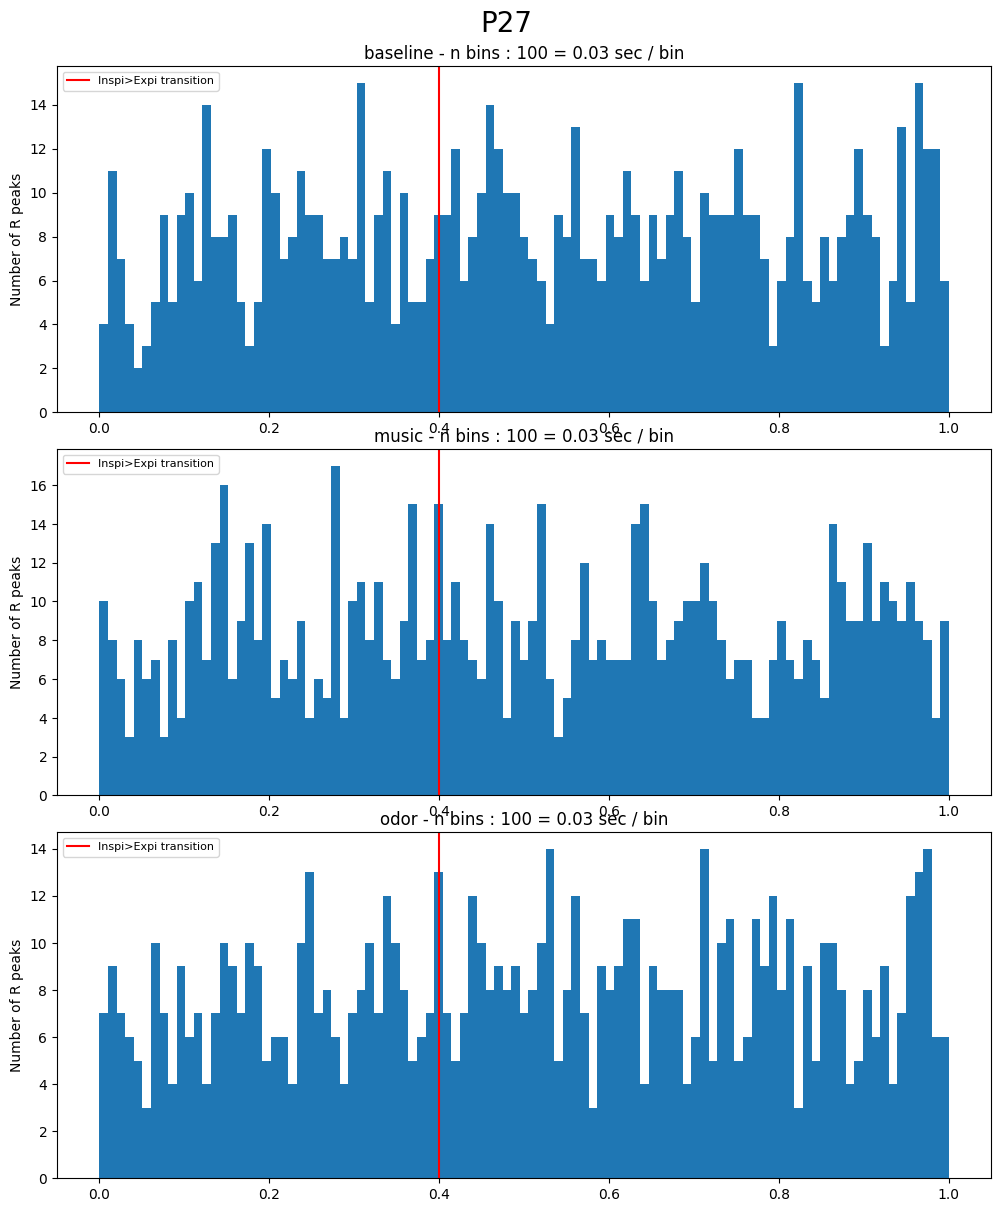

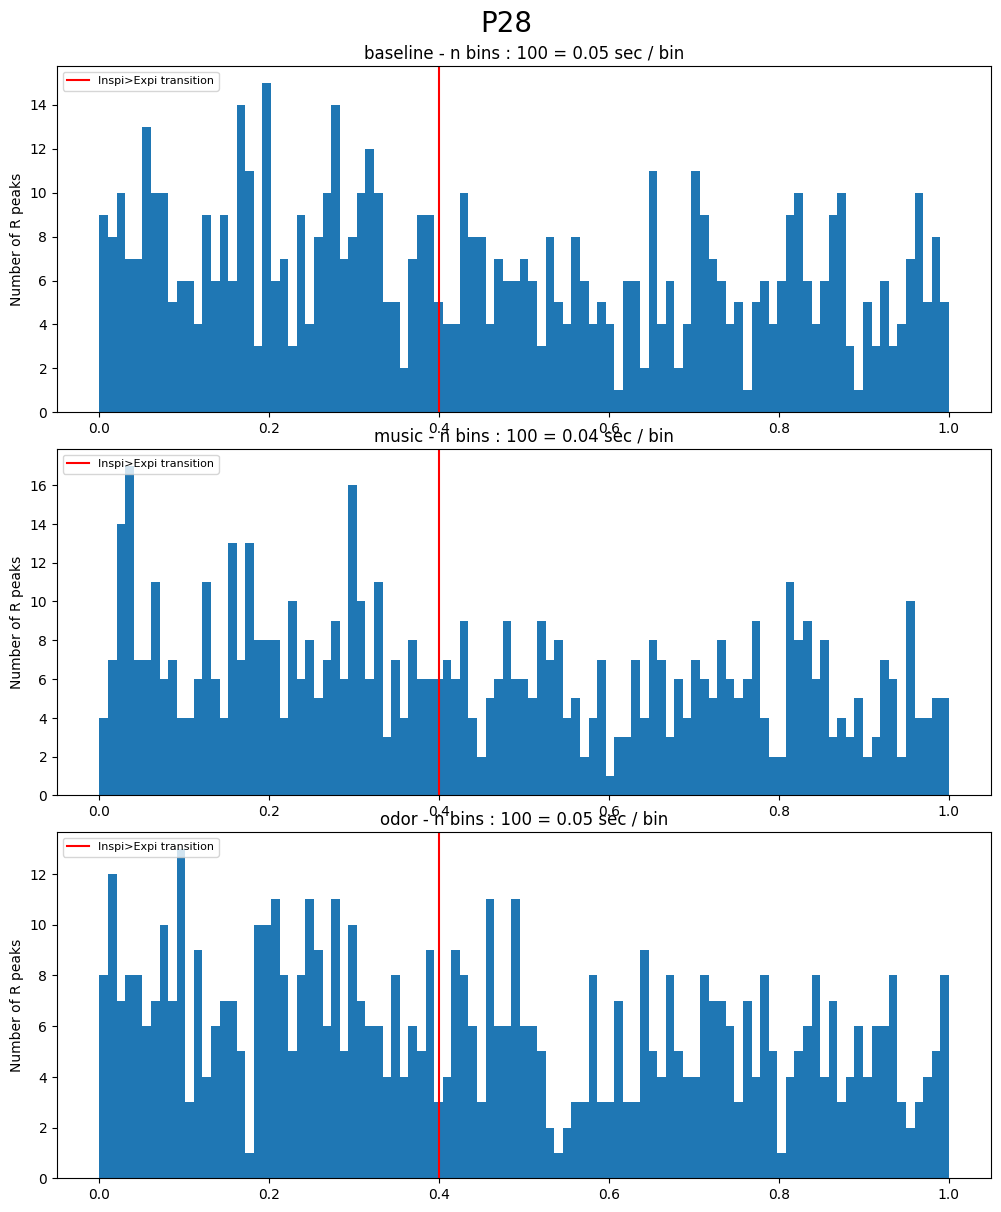

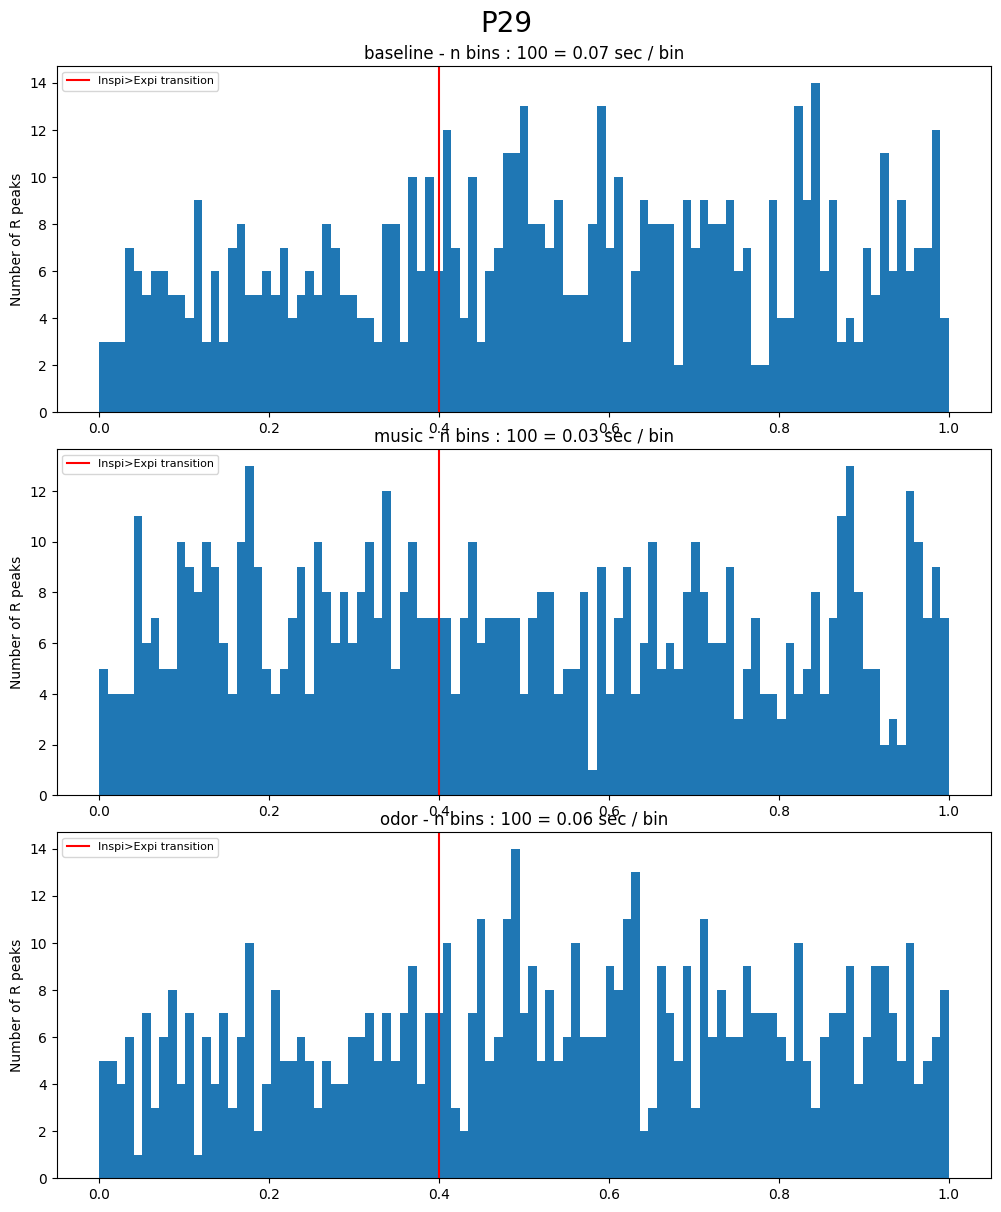

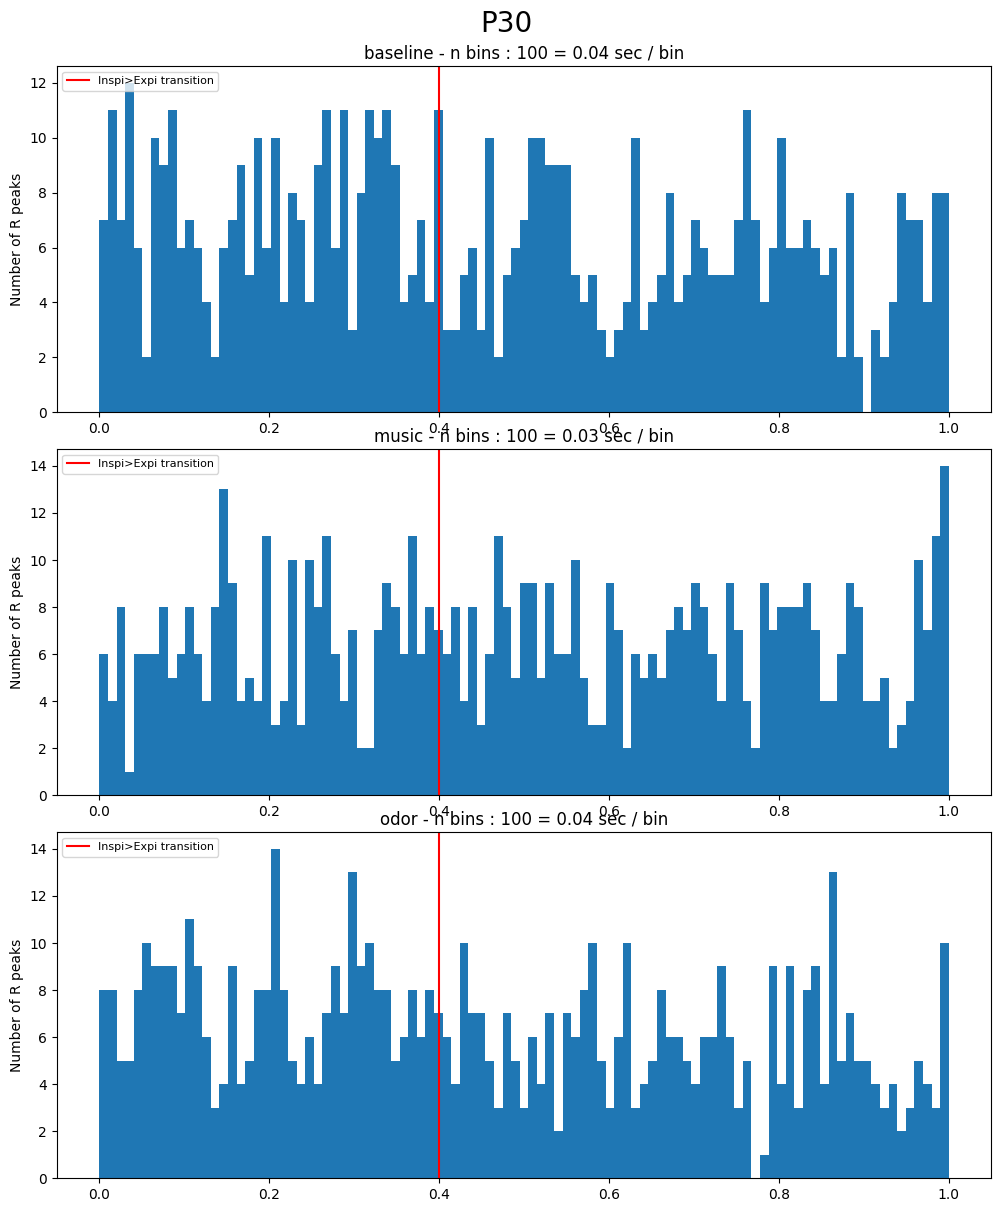

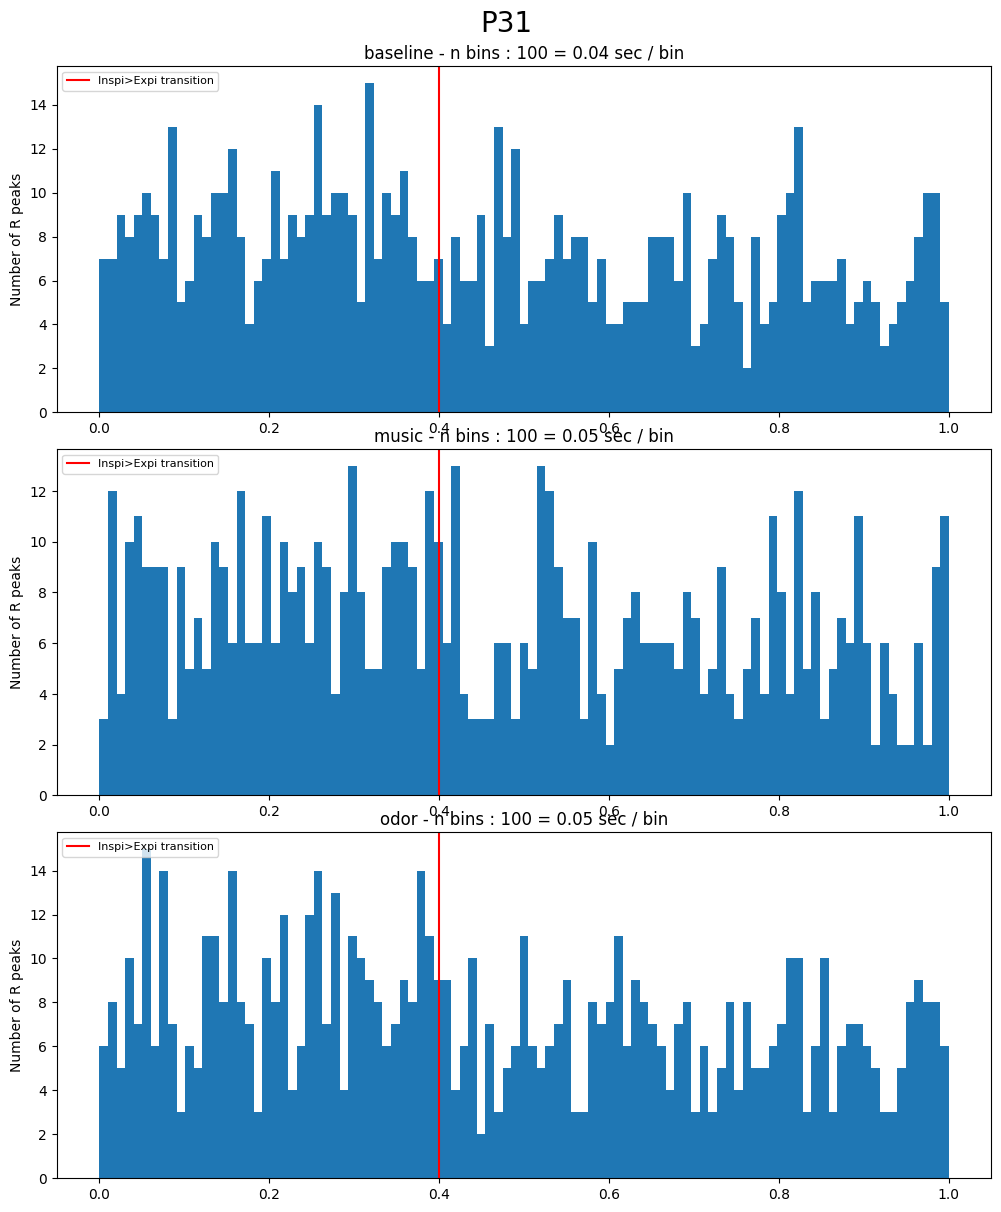

In [16]:
inspi_ratio = 0.4
n_bins = 100

for sub in subject_keys:
    fig, axs = plt.subplots(nrows = len(session_keys), figsize = (10,12), constrained_layout = True)
    fig.suptitle(sub, fontsize = 20)
    for r, ses in enumerate(session_keys):
        ax = axs[r]
        
        resp_cycles = respiration_features_job.get(sub, ses).to_dataframe()
        m_cycle_duration = resp_cycles['cycle_duration'].median()
        ecg_peaks = ecg_peak_job.get(sub, ses).to_dataframe()

        cycles = time_to_cycle(times = ecg_peaks['peak_time'], cycle_times = resp_cycles[['inspi_time','expi_time','next_inspi_time']].values, inspi_ratio = inspi_ratio)
        ax.hist(cycles % 1, bins = np.linspace(0,1,n_bins))
        ax.set_title(f'{ses} - n bins : {n_bins} = {round(m_cycle_duration / n_bins, 2)} sec / bin')
        ax.axvline(inspi_ratio, color = 'r', label = 'Inspi>Expi transition')
        # ax.set_xlabel('Respiratory phase (0-1)')
        ax.set_ylabel('Number of R peaks')
        ax.legend(fontsize = 8, loc = 2)
        fig.savefig(base_folder / 'Figures' / 'ecg_peak_phase_coupling_resp' / f'{sub}.png', dpi = 500, bbox_inches = 'tight')
    plt.show()
    